In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from category_encoders.leave_one_out import LeaveOneOutEncoder

from category_encoders.wrapper import NestedCVWrapper

from sklearn.preprocessing import OneHotEncoder

In [3]:
import optuna
from optuna.exceptions import TrialPruned
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Levanto DF

In [18]:
df = pd.read_csv('tp/train.csv')


oot = pd.read_csv('tp/oot.csv')


In [19]:
oot.shape

(211326, 903)

In [20]:
df.shape

(878894, 903)

In [21]:
df.head()

,indice,mes,target,variable_38,variable_40,variable_46,variable_39,variable_172,variable_488,variable_168,...,variable_855,variable_334,variable_755,variable_21,variable_561,variable_37,variable_20,variable_41,variable_555,variable_1067
0,0,2021-09-01,0.0,NaN,-1.0,1.0,NaN,0.0,2.0,289.0,...,0.000,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,BR-SC
1,1,2021-03-01,0.0,NaN,NaN,NaN,NaN,0.0,9.0,114.0,...,0.029,0.0,0.00,NaN,04. Nubank,NaN,NaN,NaN,01. SIN CLASI,BR-PR
2,2,2021-07-01,0.0,NaN,NaN,NaN,NaN,0.0,1.0,13.0,...,NaN,0.0,0.00,NaN,03. Mid / Low,NaN,NaN,NaN,01. SIN CLASI,BR-BA
3,3,2021-07-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,25.0,...,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,BR-PR
4,4,2021-08-01,0.0,NaN,NaN,NaN,NaN,0.0,7.0,51.0,...,0.000,0.0,46.11,NaN,04. Nubank,NaN,NaN,NaN,01. SIN CLASI,BR-SP


In [22]:
oot.head()

,indice,mes,target,variable_38,variable_40,variable_46,variable_39,variable_172,variable_488,variable_168,...,variable_855,variable_334,variable_755,variable_21,variable_561,variable_37,variable_20,variable_41,variable_555,variable_1067
0,18,2022-03-01,0.0,NaN,-1.0,7.0,NaN,NaN,0.0,NaN,...,0.143,0.0,0.0,kyc-level-6,None,None,person,None,None,BR-AM
1,19,2022-02-01,0.0,NaN,-1.0,3.0,NaN,0.0,4.0,51.0,...,0.226,0.0,0.0,None,04. Nubank,None,None,None,04. GOLD,BR-RJ
2,26,2022-03-01,0.0,NaN,-1.0,6.0,NaN,0.0,0.0,1.0,...,NaN,0.0,0.0,None,None,None,None,None,None,None
3,38,2022-03-01,0.0,NaN,-1.0,3.0,NaN,0.0,5.0,32.0,...,0.000,0.0,0.0,kyc-level-6,03. Mid / Low,None,person,None,01. SIN CLASI,BR-RS
4,46,2022-03-01,0.0,NaN,-1.0,5.0,NaN,0.0,6.0,14.0,...,0.167,0.0,0.0,kyc-level-6,None,None,person,None,None,BR-SP


# Esquema de Columnas

In [27]:
numeric_features = df.select_dtypes(include='number').columns
object_features = df.select_dtypes(include='object').columns

numeric_features = [ x for x in numeric_features if x not in ['indice','mes','target']]
object_features = [ x for x in object_features if x not in ['indice','mes','target']]

In [28]:
print("Cantidad de Columnas Numericas: "+ str(len(numeric_features)))
print("Cantidad de Columnas Categoricas: "+ str(len(object_features)))

Cantidad de Columnas Numericas: 895
Cantidad de Columnas Categoricas: 5


In [29]:
df.target.isna().sum()

1

# Split Train Test 

In [23]:

df2 = df.dropna(subset=['target'])
df2.head()

,indice,mes,target,variable_38,variable_40,variable_46,variable_39,variable_172,variable_488,variable_168,...,variable_855,variable_334,variable_755,variable_21,variable_561,variable_37,variable_20,variable_41,variable_555,variable_1067
0,0,2021-09-01,0.0,NaN,-1.0,1.0,NaN,0.0,2.0,289.0,...,0.000,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,BR-SC
1,1,2021-03-01,0.0,NaN,NaN,NaN,NaN,0.0,9.0,114.0,...,0.029,0.0,0.00,NaN,04. Nubank,NaN,NaN,NaN,01. SIN CLASI,BR-PR
2,2,2021-07-01,0.0,NaN,NaN,NaN,NaN,0.0,1.0,13.0,...,NaN,0.0,0.00,NaN,03. Mid / Low,NaN,NaN,NaN,01. SIN CLASI,BR-BA
3,3,2021-07-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,25.0,...,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,BR-PR
4,4,2021-08-01,0.0,NaN,NaN,NaN,NaN,0.0,7.0,51.0,...,0.000,0.0,46.11,NaN,04. Nubank,NaN,NaN,NaN,01. SIN CLASI,BR-SP


In [24]:
X, X_val, y, y_val = train_test_split(df2.drop(['target'],axis=1),df2.target, test_size=0.3, random_state=42,stratify=df2.target)


# Transformacion de Variables 

In [30]:
cols_tr =  numeric_features + object_features


In [36]:
fill_nan_defaults = {
    "numerical": -999,
    "categorical": "null",
    'ignored' : "null"
}

In [37]:
#ignored_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant',fill_value=fill_nan_defaults['ignored']))])
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant',fill_value=fill_nan_defaults['numerical']))])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant',fill_value=fill_nan_defaults['categorical'])),
                            ('loenc', NestedCVWrapper(LeaveOneOutEncoder(random_state=17),cv = 5 , random_state=42))])


preprocessor = ColumnTransformer(
    transformers=[
    #    ("ignored", ignored_transformer, ignored_features),
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, object_features),
    ]
)

In [38]:
X_pre = preprocessor.fit_transform(X,y)
X_val_pre = preprocessor.transform(X_val)

In [39]:
X_pre.shape

(615225, 900)

In [40]:
len(cols_tr)

900

In [41]:
[x for x in df2.columns if x not in cols_tr]

['indice', 'mes', 'target']

# Optuna

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, random_state=42, stratify=y)


In [23]:
print("len y_train: "+ str(len(y_train)))
print("len y_test: "+ str(len(y_test)))
print("len y: "+ str(len(y)))
print("len y_val: "+ str(len(y_val)))

len y_train: 492180
len y_test: 123045
len y: 615225
len y_val: 263668


In [24]:
import optuna.integration.lightgbm as lgb

In [25]:
import optuna.integration.lightgbm as lgb
def default_objective(trial):

    param = {
                "objective"        : "binary",
                "metric"           : "f1",
                "verbosity"        : -1,
                "boosting_type"    : "gbdt",
                "is_unbalance"     : "true",
                "num_leaves"       : trial.suggest_int("num_leaves", 2, 12),
                "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", int(0.003*len(X_train)), int(0.03*len(X_train))),
                "n_estimators"     : trial.suggest_int("n_estimators", 50, 300),
                "learning_rate"   : trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
                "reg_alpha": trial.suggest_loguniform('reg_alpha', 1e-1, 1e1),
                "reg_lambda": trial.suggest_loguniform('reg_lambda', 1e-1, 1e1),
                "min_split_gain": trial.suggest_loguniform('min_split_gain', 1e-5, 1e0),
                "colsample_bytree" : trial.suggest_uniform('colsample_bytree', 0.25, 0.9),
                "subsample"        : 1
            }
    
    #model_pipeline  = make_pipeline(pre_pipe, LGBMClassifier(**param, silent=True,
                                                                # metric='auc',
    model_pipeline = make_pipeline(None, LGBMClassifier(**param, n_jobs=-1
                                                                ))                                          
    m = model_pipeline.fit(X_train, y_train)
    
    preds           = m.predict_proba(X_test)[:, 1]
    roc_score       = roc_auc_score(y_test, preds)
    preds_train     = m.predict_proba(X_train)[:, 1]
    roc_score_train = roc_auc_score(y_train, preds_train)
    trial.set_user_attr('overfit', roc_score_train - roc_score)
    if roc_score_train - roc_score < 0.045:
        return roc_score
    raise TrialPruned()

    if objective  == None:
        objective = default_objective
    else:
        objective = objective

In [26]:
def do_optuna_tuning(minimize_overfit = True):
    study = optuna.create_study(direction = "maximize")
    study.optimize(default_objective, n_trials = 250,n_jobs=-1)

    if minimize_overfit:
        trial      = study.best_trial
        best_trial = sorted([t for t in study.trials if t.value != None and t.value >= trial.value - 0.0005],
                            key = lambda a: a.user_attrs['overfit'])[0]
    else:
        best_trial = study.best_trial
    params         = best_trial.params
    params.update({'random_state': 42}) 
    return study,trial,best_trial

In [27]:
study,trial,best_trial=do_optuna_tuning()

[I 2022-07-01 13:48:30,355] A new study created in memory with name: no-name-0d2c2ecd-a70e-4b54-b4d3-17dacf041df5


[LightGBM] [Warning] min_data_in_leaf is set=13869, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13869
[LightGBM] [Warning] min_data_in_leaf is set=14275, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14275
[LightGBM] [Warning] min_data_in_leaf is set=10782, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10782


/root/.cache/pypoetry/virtualenvs/app-tLMLSx4L-py3.7/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


[LightGBM] [Warning] min_data_in_leaf is set=2745, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2745
[LightGBM] [Warning] min_data_in_leaf is set=12429, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12429
[LightGBM] [Warning] min_data_in_leaf is set=9142, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9142
[LightGBM] [Warning] min_data_in_leaf is set=10396, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10396
[LightGBM] [Warning] min_data_in_leaf is set=8041, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8041
[LightGBM] [Warning] min_data_in_leaf is set=10390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10390
[LightGBM] [Warning] min_data_in_leaf is set=5045, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5045
[LightGBM] [Warning] min_data_in_leaf is set=12436, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-07-01 13:50:47,620] Trial 5 finished with value: 0.6720893363160167 and parameters: {'num_leaves': 7, 'min_data_in_leaf': 8041, 'n_estimators': 59, 'learning_rate': 0.0001862539983079183, 'reg_alpha': 3.2436411230086057, 'reg_lambda': 2.2406458543471266, 'min_split_gain': 0.1335756063555241, 'colsample_bytree': 0.7185002512382831}. Best is trial 5 with value: 0.6720893363160167.


[LightGBM] [Warning] min_data_in_leaf is set=1565, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1565


[I 2022-07-01 13:50:50,345] Trial 17 finished with value: 0.6635285615820193 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 13267, 'n_estimators': 82, 'learning_rate': 0.0028870948160635507, 'reg_alpha': 1.288751498934786, 'reg_lambda': 7.744306879878297, 'min_split_gain': 0.7504478009241244, 'colsample_bytree': 0.7474310018021213}. Best is trial 5 with value: 0.6720893363160167.


[LightGBM] [Warning] min_data_in_leaf is set=5281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5281


[I 2022-07-01 13:50:57,984] Trial 10 finished with value: 0.6665974943299595 and parameters: {'num_leaves': 5, 'min_data_in_leaf': 10396, 'n_estimators': 74, 'learning_rate': 6.747692318073505e-05, 'reg_alpha': 0.12980621224591204, 'reg_lambda': 4.061634289422946, 'min_split_gain': 0.004605143124037229, 'colsample_bytree': 0.6832664122816599}. Best is trial 5 with value: 0.6720893363160167.


[LightGBM] [Warning] min_data_in_leaf is set=12324, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12324


[I 2022-07-01 13:51:06,001] Trial 7 finished with value: 0.6640050703409641 and parameters: {'num_leaves': 2, 'min_data_in_leaf': 11298, 'n_estimators': 78, 'learning_rate': 0.00663499174543686, 'reg_alpha': 6.392219651680261, 'reg_lambda': 9.52786207611481, 'min_split_gain': 0.7616701384013084, 'colsample_bytree': 0.39058616282265224}. Best is trial 5 with value: 0.6720893363160167.


[LightGBM] [Warning] min_data_in_leaf is set=1763, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1763


[I 2022-07-01 13:51:15,706] Trial 13 finished with value: 0.6451585211107971 and parameters: {'num_leaves': 2, 'min_data_in_leaf': 12436, 'n_estimators': 199, 'learning_rate': 0.0007958478569929319, 'reg_alpha': 2.2256144801551643, 'reg_lambda': 0.13939966612132618, 'min_split_gain': 5.2725974998242496e-05, 'colsample_bytree': 0.831730248183793}. Best is trial 5 with value: 0.6720893363160167.


[LightGBM] [Warning] min_data_in_leaf is set=14154, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14154


[I 2022-07-01 13:51:23,875] Trial 24 finished with value: 0.6652193965149495 and parameters: {'num_leaves': 3, 'min_data_in_leaf': 9999, 'n_estimators': 103, 'learning_rate': 0.0011940653485316224, 'reg_alpha': 1.5362718842528016, 'reg_lambda': 0.41897158174561844, 'min_split_gain': 3.040694519274333e-05, 'colsample_bytree': 0.4040667769715547}. Best is trial 5 with value: 0.6720893363160167.


[LightGBM] [Warning] min_data_in_leaf is set=5685, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5685


[I 2022-07-01 13:51:27,620] Trial 38 finished with value: 0.6862496404131877 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 13704, 'n_estimators': 61, 'learning_rate': 0.0002584522303964246, 'reg_alpha': 2.4373751892338067, 'reg_lambda': 0.4031379958102186, 'min_split_gain': 0.5561543581759713, 'colsample_bytree': 0.4048897740606289}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=3291, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3291


[I 2022-07-01 13:51:39,018] Trial 33 finished with value: 0.6551173260674532 and parameters: {'num_leaves': 2, 'min_data_in_leaf': 2714, 'n_estimators': 164, 'learning_rate': 0.002881394248506803, 'reg_alpha': 2.3378506670474355, 'reg_lambda': 5.116230801755524, 'min_split_gain': 0.08789725747088845, 'colsample_bytree': 0.4820144133400631}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=10700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10700


[I 2022-07-01 13:51:41,115] Trial 21 finished with value: 0.6780214624823538 and parameters: {'num_leaves': 8, 'min_data_in_leaf': 6897, 'n_estimators': 84, 'learning_rate': 0.00021782692332677177, 'reg_alpha': 8.21265195704323, 'reg_lambda': 1.547180210933881, 'min_split_gain': 0.0007682711310379842, 'colsample_bytree': 0.6973968900729531}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=4118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4118


[I 2022-07-01 13:51:42,493] Trial 6 finished with value: 0.6623520087191115 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 2745, 'n_estimators': 121, 'learning_rate': 0.0018938036018239107, 'reg_alpha': 0.34433927352248234, 'reg_lambda': 2.012097069106941, 'min_split_gain': 0.04122629183829903, 'colsample_bytree': 0.8776287181332687}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=14261, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14261


[I 2022-07-01 13:51:46,863] Trial 37 finished with value: 0.6859848477462198 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3156, 'n_estimators': 58, 'learning_rate': 3.335692087517334e-05, 'reg_alpha': 0.49906749163872405, 'reg_lambda': 1.5067914558489945, 'min_split_gain': 0.00021391830974111373, 'colsample_bytree': 0.352642026893915}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=5770, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5770


[I 2022-07-01 13:51:58,361] Trial 36 finished with value: 0.6406323952291226 and parameters: {'num_leaves': 2, 'min_data_in_leaf': 13282, 'n_estimators': 155, 'learning_rate': 5.300799970645596e-05, 'reg_alpha': 0.793364894160528, 'reg_lambda': 5.366124596887034, 'min_split_gain': 0.3538197697060804, 'colsample_bytree': 0.5706894665005042}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=5074, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5074


[I 2022-07-01 13:52:03,267] Trial 28 finished with value: 0.6862431867407474 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 10525, 'n_estimators': 155, 'learning_rate': 0.009112330827216396, 'reg_alpha': 0.20412482487649616, 'reg_lambda': 1.27006996528027, 'min_split_gain': 0.10559218191753755, 'colsample_bytree': 0.3941562786751884}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=14634, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14634


[I 2022-07-01 13:52:08,463] Trial 3 finished with value: 0.6426117170040062 and parameters: {'num_leaves': 2, 'min_data_in_leaf': 14275, 'n_estimators': 242, 'learning_rate': 3.9532110838663545e-05, 'reg_alpha': 1.6910701867234628, 'reg_lambda': 1.246009661981739, 'min_split_gain': 0.03850508600237239, 'colsample_bytree': 0.5586026887501045}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=6001, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6001


[I 2022-07-01 13:52:10,244] Trial 22 finished with value: 0.6782012579467586 and parameters: {'num_leaves': 6, 'min_data_in_leaf': 9037, 'n_estimators': 136, 'learning_rate': 0.0018674061486520105, 'reg_alpha': 6.507227071716368, 'reg_lambda': 0.735948665495799, 'min_split_gain': 0.04889354587324745, 'colsample_bytree': 0.6425926035535177}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=5986, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5986


[I 2022-07-01 13:52:14,850] Trial 1 finished with value: 0.6616898841551057 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 13869, 'n_estimators': 209, 'learning_rate': 3.140652421433112e-05, 'reg_alpha': 1.1533765023225908, 'reg_lambda': 0.2016373976645907, 'min_split_gain': 0.7841798484500244, 'colsample_bytree': 0.7065752369846867}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=5709, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5709


[I 2022-07-01 13:52:21,077] Trial 27 finished with value: 0.6715885727727078 and parameters: {'num_leaves': 7, 'min_data_in_leaf': 7497, 'n_estimators': 124, 'learning_rate': 1.1245361192757617e-05, 'reg_alpha': 1.513612768376053, 'reg_lambda': 5.502270377833, 'min_split_gain': 0.002473045129220814, 'colsample_bytree': 0.8515409032639231}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=5883, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5883


[I 2022-07-01 13:52:30,901] Trial 8 finished with value: 0.675656839174068 and parameters: {'num_leaves': 5, 'min_data_in_leaf': 11199, 'n_estimators': 169, 'learning_rate': 0.0002903379530142301, 'reg_alpha': 0.8499292376664743, 'reg_lambda': 2.4912678695948838, 'min_split_gain': 0.0024725305196666193, 'colsample_bytree': 0.4679399346837424}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=5269, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5269


[I 2022-07-01 13:52:47,858] Trial 14 finished with value: 0.6755244859643825 and parameters: {'num_leaves': 6, 'min_data_in_leaf': 4711, 'n_estimators': 132, 'learning_rate': 8.909754143097088e-05, 'reg_alpha': 0.7174060977152843, 'reg_lambda': 7.99538070719511, 'min_split_gain': 0.25749728723853926, 'colsample_bytree': 0.51079319657561}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=12147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12147


[I 2022-07-01 13:52:50,480] Trial 15 finished with value: 0.6600334631893614 and parameters: {'num_leaves': 3, 'min_data_in_leaf': 2904, 'n_estimators': 250, 'learning_rate': 0.0005110911376839538, 'reg_alpha': 0.8356025047699118, 'reg_lambda': 0.7269619188314919, 'min_split_gain': 0.000982779832965818, 'colsample_bytree': 0.6199760446592357}. Best is trial 38 with value: 0.6862496404131877.


[LightGBM] [Warning] min_data_in_leaf is set=6028, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6028


[I 2022-07-01 13:53:04,685] Trial 9 finished with value: 0.6893328596834862 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 10390, 'n_estimators': 138, 'learning_rate': 0.0028637559278380277, 'reg_alpha': 0.3272512129983536, 'reg_lambda': 0.5827755083087216, 'min_split_gain': 2.1832817211456177e-05, 'colsample_bytree': 0.4852618233068386}. Best is trial 9 with value: 0.6893328596834862.


[LightGBM] [Warning] min_data_in_leaf is set=11962, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11962


[I 2022-07-01 13:53:08,711] Trial 16 finished with value: 0.6437888171471187 and parameters: {'num_leaves': 2, 'min_data_in_leaf': 5045, 'n_estimators': 258, 'learning_rate': 2.256137235820631e-05, 'reg_alpha': 2.341830281225337, 'reg_lambda': 2.9137268801515175, 'min_split_gain': 0.00015370774073218872, 'colsample_bytree': 0.5254155079159748}. Best is trial 9 with value: 0.6893328596834862.


[LightGBM] [Warning] min_data_in_leaf is set=12148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12148


[I 2022-07-01 13:53:11,155] Trial 39 finished with value: 0.674034936456695 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 8384, 'n_estimators': 209, 'learning_rate': 0.00016369839185113234, 'reg_alpha': 2.198292290538983, 'reg_lambda': 0.6137429194067526, 'min_split_gain': 0.014116681808987288, 'colsample_bytree': 0.25665131172924527}. Best is trial 9 with value: 0.6893328596834862.


[LightGBM] [Warning] min_data_in_leaf is set=12268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12268


[I 2022-07-01 13:53:31,534] Trial 31 finished with value: 0.6896182376916131 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 4288, 'n_estimators': 260, 'learning_rate': 0.007985638239103974, 'reg_alpha': 0.9388637048051747, 'reg_lambda': 0.401315782685226, 'min_split_gain': 4.355746928289151e-05, 'colsample_bytree': 0.766253970306395}. Best is trial 31 with value: 0.6896182376916131.


[LightGBM] [Warning] min_data_in_leaf is set=6153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6153


[I 2022-07-01 13:53:39,821] Trial 11 finished with value: 0.6870263233475074 and parameters: {'num_leaves': 6, 'min_data_in_leaf': 11575, 'n_estimators': 192, 'learning_rate': 0.0035401928338007955, 'reg_alpha': 0.11978124961816967, 'reg_lambda': 0.25046203196732936, 'min_split_gain': 1.2149134049149856e-05, 'colsample_bytree': 0.4875414267546808}. Best is trial 31 with value: 0.6896182376916131.


[LightGBM] [Warning] min_data_in_leaf is set=5714, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5714


[I 2022-07-01 13:53:50,743] Trial 4 finished with value: 0.6899366212828755 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 10782, 'n_estimators': 193, 'learning_rate': 0.0020156914492061623, 'reg_alpha': 0.10821005508142909, 'reg_lambda': 1.2453728039182304, 'min_split_gain': 0.027812747712377302, 'colsample_bytree': 0.44165317850459496}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=1535, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1535


[I 2022-07-01 13:53:54,940] Trial 40 finished with value: 0.6848466176307837 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 1565, 'n_estimators': 94, 'learning_rate': 1.1702132412754295e-05, 'reg_alpha': 5.06407047657362, 'reg_lambda': 0.7433113415634707, 'min_split_gain': 0.00043483153329551544, 'colsample_bytree': 0.49231385626175145}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=6271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6271


[I 2022-07-01 13:53:56,591] Trial 18 finished with value: 0.6783899410299856 and parameters: {'num_leaves': 7, 'min_data_in_leaf': 10745, 'n_estimators': 190, 'learning_rate': 3.5193718108190825e-05, 'reg_alpha': 0.23727304822584636, 'reg_lambda': 4.668366860025698, 'min_split_gain': 0.02097440386065247, 'colsample_bytree': 0.5499657061434935}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=6364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6364


[I 2022-07-01 13:53:57,625] Trial 32 finished with value: 0.684066841740036 and parameters: {'num_leaves': 8, 'min_data_in_leaf': 1801, 'n_estimators': 198, 'learning_rate': 0.0005515215093849428, 'reg_alpha': 0.14602149554125257, 'reg_lambda': 0.9937125602997032, 'min_split_gain': 6.919345849694652e-05, 'colsample_bytree': 0.3503742286029087}. Best is trial 4 with value: 0.6899366212828755.
[I 2022-07-01 13:53:58,015] Trial 12 finished with value: 0.6818332861602103 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 3483, 'n_estimators': 176, 'learning_rate': 2.838881032768472e-05, 'reg_alpha': 0.38676892004611924, 'reg_lambda': 2.1183077292810335, 'min_split_gain': 0.16329462534820222, 'colsample_bytree': 0.2517693995150832}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=5793, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5793
[LightGBM] [Warning] min_data_in_leaf is set=5840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5840


[I 2022-07-01 13:54:04,149] Trial 23 finished with value: 0.6767895976635626 and parameters: {'num_leaves': 6, 'min_data_in_leaf': 10425, 'n_estimators': 209, 'learning_rate': 5.446107623876773e-05, 'reg_alpha': 3.083962517570346, 'reg_lambda': 0.4695015461844095, 'min_split_gain': 0.013410552765519139, 'colsample_bytree': 0.4948492183508075}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=12038, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12038


[I 2022-07-01 13:54:17,746] Trial 0 finished with value: 0.6795618837628328 and parameters: {'num_leaves': 8, 'min_data_in_leaf': 9142, 'n_estimators': 283, 'learning_rate': 1.2529904924752409e-05, 'reg_alpha': 4.311011391445599, 'reg_lambda': 0.19005082773834478, 'min_split_gain': 0.015564687202914944, 'colsample_bytree': 0.29299178188223196}. Best is trial 4 with value: 0.6899366212828755.
[I 2022-07-01 13:54:17,919] Trial 19 finished with value: 0.6820486405286472 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 12662, 'n_estimators': 188, 'learning_rate': 0.0011809159112137013, 'reg_alpha': 0.7959493931538091, 'reg_lambda': 3.769377430421068, 'min_split_gain': 0.0005993567210538488, 'colsample_bytree': 0.8803653582390688}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=11858, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11858
[LightGBM] [Warning] min_data_in_leaf is set=11745, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11745


[I 2022-07-01 13:54:27,278] Trial 30 finished with value: 0.6757930717614495 and parameters: {'num_leaves': 5, 'min_data_in_leaf': 6073, 'n_estimators': 290, 'learning_rate': 0.0015514989976368328, 'reg_alpha': 3.023474523526794, 'reg_lambda': 0.6033150379654052, 'min_split_gain': 6.577727651682871e-05, 'colsample_bytree': 0.8851047176017517}. Best is trial 4 with value: 0.6899366212828755.
[I 2022-07-01 13:54:27,483] Trial 46 finished with value: 0.6505802381162383 and parameters: {'num_leaves': 2, 'min_data_in_leaf': 3291, 'n_estimators': 89, 'learning_rate': 0.003060211648310673, 'reg_alpha': 7.328941744023865, 'reg_lambda': 2.1450443976920797, 'min_split_gain': 0.0002907148363054367, 'colsample_bytree': 0.5391367672290797}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=9660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9660
[LightGBM] [Warning] min_data_in_leaf is set=14729, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14729


[I 2022-07-01 13:54:30,335] Trial 2 finished with value: 0.6868521296645083 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 12429, 'n_estimators': 206, 'learning_rate': 0.0014416751765243352, 'reg_alpha': 0.8023289907754516, 'reg_lambda': 1.3265261898118026, 'min_split_gain': 0.00014154183427025083, 'colsample_bytree': 0.5454906345102357}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=14722, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14722


[I 2022-07-01 13:54:38,248] Trial 35 finished with value: 0.6826079932404968 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 11131, 'n_estimators': 205, 'learning_rate': 0.000308627826092105, 'reg_alpha': 5.42153724040419, 'reg_lambda': 0.10754682481994907, 'min_split_gain': 0.011006696504325376, 'colsample_bytree': 0.7211860610883438}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=9409, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9409


[I 2022-07-01 13:54:56,475] Trial 47 finished with value: 0.682073780526981 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 10700, 'n_estimators': 85, 'learning_rate': 0.00048630255493518454, 'reg_alpha': 0.204736417860921, 'reg_lambda': 0.9134024093855738, 'min_split_gain': 0.0008034550623676815, 'colsample_bytree': 0.7858348225651836}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=8964, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8964


[I 2022-07-01 13:55:06,957] Trial 42 finished with value: 0.6813942378687876 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 12324, 'n_estimators': 153, 'learning_rate': 0.00028807128143589085, 'reg_alpha': 1.454761540430689, 'reg_lambda': 4.072620359634687, 'min_split_gain': 0.09680021383019463, 'colsample_bytree': 0.664111145742371}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=9503, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9503


[I 2022-07-01 13:55:08,840] Trial 41 finished with value: 0.6697642692918528 and parameters: {'num_leaves': 3, 'min_data_in_leaf': 5281, 'n_estimators': 299, 'learning_rate': 2.0230615128323516e-05, 'reg_alpha': 1.9359813439078961, 'reg_lambda': 0.8143267786241346, 'min_split_gain': 0.0007401324348940143, 'colsample_bytree': 0.4160845562139886}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=9452, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9452


[I 2022-07-01 13:55:24,774] Trial 26 finished with value: 0.6832699851008139 and parameters: {'num_leaves': 8, 'min_data_in_leaf': 13732, 'n_estimators': 282, 'learning_rate': 0.00023060281419751916, 'reg_alpha': 1.0510751283638824, 'reg_lambda': 0.3436176310418822, 'min_split_gain': 0.013202895146859238, 'colsample_bytree': 0.3918233099636338}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=14698, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14698


[I 2022-07-01 13:55:31,026] Trial 25 finished with value: 0.6872628424841394 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 10433, 'n_estimators': 213, 'learning_rate': 2.5155607116200306e-05, 'reg_alpha': 0.2869699015715941, 'reg_lambda': 0.9236711231583943, 'min_split_gain': 0.00044403992679392385, 'colsample_bytree': 0.5445045084640263}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=9454, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9454


[I 2022-07-01 13:55:37,993] Trial 20 finished with value: 0.6692355615272136 and parameters: {'num_leaves': 4, 'min_data_in_leaf': 4512, 'n_estimators': 300, 'learning_rate': 0.00043857096363597494, 'reg_alpha': 6.91369500053489, 'reg_lambda': 0.9692030167696131, 'min_split_gain': 0.267888627578624, 'colsample_bytree': 0.5361110450735744}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=9298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9298


[I 2022-07-01 13:55:41,452] Trial 34 finished with value: 0.6850662073442704 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 14083, 'n_estimators': 252, 'learning_rate': 0.00011149382133245525, 'reg_alpha': 0.2829376371503562, 'reg_lambda': 1.0545464009967147, 'min_split_gain': 0.2509464757301073, 'colsample_bytree': 0.5330111581391707}. Best is trial 4 with value: 0.6899366212828755.


[LightGBM] [Warning] min_data_in_leaf is set=9465, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9465


[I 2022-07-01 13:55:52,636] Trial 29 finished with value: 0.6973931817575573 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 13985, 'n_estimators': 285, 'learning_rate': 0.005307795628487969, 'reg_alpha': 7.7448734024055765, 'reg_lambda': 0.9763236817683613, 'min_split_gain': 0.21875787104138078, 'colsample_bytree': 0.7206240728043347}. Best is trial 29 with value: 0.6973931817575573.


[LightGBM] [Warning] min_data_in_leaf is set=9685, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9685


[I 2022-07-01 13:56:18,690] Trial 45 finished with value: 0.6978988169179587 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 5685, 'n_estimators': 186, 'learning_rate': 0.00791830858327119, 'reg_alpha': 0.16402374771502348, 'reg_lambda': 0.19040772701835101, 'min_split_gain': 0.00011182425929103625, 'colsample_bytree': 0.271856729166024}. Best is trial 45 with value: 0.6978988169179587.


[LightGBM] [Warning] min_data_in_leaf is set=9564, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9564


[I 2022-07-01 13:56:58,985] Trial 48 finished with value: 0.6822255468945797 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 4118, 'n_estimators': 209, 'learning_rate': 0.0017818247180094702, 'reg_alpha': 6.4220063297003875, 'reg_lambda': 0.3203307078205712, 'min_split_gain': 1.1572114910418739e-05, 'colsample_bytree': 0.8697448086954963}. Best is trial 45 with value: 0.6978988169179587.


[LightGBM] [Warning] min_data_in_leaf is set=9647, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9647


[I 2022-07-01 13:57:18,154] Trial 62 finished with value: 0.6949736785154407 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 12268, 'n_estimators': 105, 'learning_rate': 0.008597487174318314, 'reg_alpha': 0.17704281789577497, 'reg_lambda': 0.3219119768259234, 'min_split_gain': 1.164353237132027e-05, 'colsample_bytree': 0.3033875831966113}. Best is trial 45 with value: 0.6978988169179587.


[LightGBM] [Warning] min_data_in_leaf is set=14685, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14685


[I 2022-07-01 13:57:34,346] Trial 43 finished with value: 0.6979513993334239 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 1763, 'n_estimators': 202, 'learning_rate': 0.007154325270930724, 'reg_alpha': 0.3215161999566356, 'reg_lambda': 0.5561915668914862, 'min_split_gain': 0.7978122761121392, 'colsample_bytree': 0.346845436229717}. Best is trial 43 with value: 0.6979513993334239.


[LightGBM] [Warning] min_data_in_leaf is set=14465, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14465


[I 2022-07-01 13:57:51,304] Trial 50 finished with value: 0.684294326636931 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 5770, 'n_estimators': 260, 'learning_rate': 1.0925465580932026e-05, 'reg_alpha': 0.47265605561594765, 'reg_lambda': 0.6099985063747407, 'min_split_gain': 0.0004197347056882018, 'colsample_bytree': 0.25902071065353444}. Best is trial 43 with value: 0.6979513993334239.


[LightGBM] [Warning] min_data_in_leaf is set=14692, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14692


[I 2022-07-01 13:57:57,317] Trial 44 finished with value: 0.6804718190380338 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 14154, 'n_estimators': 249, 'learning_rate': 0.0003277930718704865, 'reg_alpha': 0.4538239173743807, 'reg_lambda': 8.726282407782453, 'min_split_gain': 0.0001551603101505694, 'colsample_bytree': 0.8831529675494431}. Best is trial 43 with value: 0.6979513993334239.


[LightGBM] [Warning] min_data_in_leaf is set=14753, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14753


[I 2022-07-01 13:57:58,825] Trial 53 finished with value: 0.6866555559062696 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 6001, 'n_estimators': 217, 'learning_rate': 0.00048062117306868826, 'reg_alpha': 0.10766978667196446, 'reg_lambda': 0.4932039250631313, 'min_split_gain': 0.00868767925443787, 'colsample_bytree': 0.30084501950264425}. Best is trial 43 with value: 0.6979513993334239.


[LightGBM] [Warning] min_data_in_leaf is set=9599, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9599


[I 2022-07-01 13:58:00,242] Trial 52 finished with value: 0.7048875778768068 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 14634, 'n_estimators': 273, 'learning_rate': 0.009844458872438205, 'reg_alpha': 0.2540326975041363, 'reg_lambda': 0.5112080837627384, 'min_split_gain': 0.02125723672974902, 'colsample_bytree': 0.2576276783401137}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=14703, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14703


[I 2022-07-01 13:58:35,654] Trial 60 finished with value: 0.6988540529592563 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 11962, 'n_estimators': 192, 'learning_rate': 0.008264049823175424, 'reg_alpha': 0.20877834797765427, 'reg_lambda': 0.350678309082, 'min_split_gain': 1.2730581543544565e-05, 'colsample_bytree': 0.2651951885080441}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=14678, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14678


[I 2022-07-01 13:58:39,414] Trial 49 finished with value: 0.6833638044524329 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 14261, 'n_estimators': 292, 'learning_rate': 1.085970479644329e-05, 'reg_alpha': 0.5078832179148999, 'reg_lambda': 0.496815466207086, 'min_split_gain': 0.0038272803213727736, 'colsample_bytree': 0.2751910183143831}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 13:58:42,091] Trial 61 finished with value: 0.6986348176449853 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 12148, 'n_estimators': 193, 'learning_rate': 0.007935520973835035, 'reg_alpha': 0.21283000336455407, 'reg_lambda': 0.3460380903282542, 'min_split_gain': 1.178438624283761e-05, 'colsample_bytree': 0.2566368590184903}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=14576, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14576
[LightGBM] [Warning] min_data_in_leaf is set=14673, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14673


[I 2022-07-01 13:59:25,134] Trial 57 finished with value: 0.686579365759433 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 5269, 'n_estimators': 274, 'learning_rate': 0.0005606652310854057, 'reg_alpha': 0.15286126210195483, 'reg_lambda': 0.4891992041013963, 'min_split_gain': 0.00837987909015288, 'colsample_bytree': 0.26780194998907236}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=14608, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14608


[I 2022-07-01 13:59:34,982] Trial 58 finished with value: 0.7043514824174587 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 12147, 'n_estimators': 270, 'learning_rate': 0.009528751518431666, 'reg_alpha': 0.1246123648722003, 'reg_lambda': 0.4905415245663532, 'min_split_gain': 0.009923169555125485, 'colsample_bytree': 0.259651596815315}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=11773, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11773


[I 2022-07-01 13:59:41,564] Trial 51 finished with value: 0.6842583419833989 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 5074, 'n_estimators': 273, 'learning_rate': 1.0611179187657222e-05, 'reg_alpha': 0.37200344315059625, 'reg_lambda': 0.54429952076021, 'min_split_gain': 0.0004457265915475798, 'colsample_bytree': 0.2737802303091453}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=11871, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11871


[I 2022-07-01 13:59:58,763] Trial 54 finished with value: 0.683534885185243 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 5986, 'n_estimators': 287, 'learning_rate': 1.2975272309077812e-05, 'reg_alpha': 0.12899481865683854, 'reg_lambda': 0.28428622020557964, 'min_split_gain': 0.006193577326129798, 'colsample_bytree': 0.2802745589611552}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=9886, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9886


[I 2022-07-01 14:00:05,650] Trial 55 finished with value: 0.682438919332448 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 5709, 'n_estimators': 298, 'learning_rate': 1.2388339591132022e-05, 'reg_alpha': 0.15525061382364547, 'reg_lambda': 0.5157444694876239, 'min_split_gain': 0.015485823249198491, 'colsample_bytree': 0.28325497827689783}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=11795, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11795


[I 2022-07-01 14:00:16,021] Trial 56 finished with value: 0.6886919579087861 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 5883, 'n_estimators': 296, 'learning_rate': 0.000561616596815444, 'reg_alpha': 0.10241626848703876, 'reg_lambda': 0.49626961718384094, 'min_split_gain': 0.008454828961894888, 'colsample_bytree': 0.29068425320198776}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=14730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14730


[I 2022-07-01 14:00:18,014] Trial 59 finished with value: 0.7048033590588039 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 6028, 'n_estimators': 289, 'learning_rate': 0.009037980817279164, 'reg_alpha': 0.10738495750957526, 'reg_lambda': 0.30334362048940566, 'min_split_gain': 0.013599570792136374, 'colsample_bytree': 0.27990447522190354}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=11912, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11912


[I 2022-07-01 14:00:50,539] Trial 70 finished with value: 0.6954841476576199 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 12038, 'n_estimators': 237, 'learning_rate': 0.0050466605336164354, 'reg_alpha': 0.11137348215881596, 'reg_lambda': 0.2437345928847109, 'min_split_gain': 1.9717523201355685e-05, 'colsample_bytree': 0.44011388423938635}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=9701, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9701


[I 2022-07-01 14:01:16,047] Trial 63 finished with value: 0.699327180420376 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 6153, 'n_estimators': 294, 'learning_rate': 0.005345189868829322, 'reg_alpha': 0.32999365101408135, 'reg_lambda': 0.3268087890244226, 'min_split_gain': 1.2561547009654773e-05, 'colsample_bytree': 0.30558888660984723}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=9229, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9229


[I 2022-07-01 14:01:33,234] Trial 75 finished with value: 0.694964648784101 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 14722, 'n_estimators': 227, 'learning_rate': 0.00533282914050559, 'reg_alpha': 0.19000022517760543, 'reg_lambda': 0.26193921656650354, 'min_split_gain': 1.0453783986587299e-05, 'colsample_bytree': 0.4486512516261249}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:01:34,790] Trial 64 finished with value: 0.6961788351977762 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 5714, 'n_estimators': 291, 'learning_rate': 0.00508871491370444, 'reg_alpha': 0.1046634408390284, 'reg_lambda': 0.26017919800482925, 'min_split_gain': 1.0825184796439829e-05, 'colsample_bytree': 0.6124520208885782}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=12912, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12912
[LightGBM] [Warning] min_data_in_leaf is set=9412, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9412


[I 2022-07-01 14:01:41,678] Trial 73 finished with value: 0.6953086698655164 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 9660, 'n_estimators': 225, 'learning_rate': 0.005108600381158439, 'reg_alpha': 0.17711668412368708, 'reg_lambda': 0.26564549891685163, 'min_split_gain': 1.0086128909829742e-05, 'colsample_bytree': 0.44058778007113475}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=6617, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6617


[I 2022-07-01 14:01:45,992] Trial 74 finished with value: 0.6969046306779235 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 14729, 'n_estimators': 232, 'learning_rate': 0.006099153547394758, 'reg_alpha': 0.10230894305037151, 'reg_lambda': 0.2725328292102992, 'min_split_gain': 1.0246799959944554e-05, 'colsample_bytree': 0.440446208405292}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:01:46,920] Trial 79 finished with value: 0.6952028346555392 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 9452, 'n_estimators': 222, 'learning_rate': 0.00510917692691801, 'reg_alpha': 0.1008576986565521, 'reg_lambda': 0.2714680610946738, 'min_split_gain': 1.3666534199401061e-05, 'colsample_bytree': 0.43684874354183917}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=6973, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6973
[LightGBM] [Warning] min_data_in_leaf is set=6862, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6862


[I 2022-07-01 14:01:47,916] Trial 67 finished with value: 0.6959988784111624 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 6364, 'n_estimators': 296, 'learning_rate': 0.005233425161324045, 'reg_alpha': 0.4464375044211109, 'reg_lambda': 0.3510881790926431, 'min_split_gain': 1.3196080329049243e-05, 'colsample_bytree': 0.7919693518253488}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=8125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8125


[I 2022-07-01 14:02:06,405] Trial 78 finished with value: 0.694198484136233 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 9503, 'n_estimators': 232, 'learning_rate': 0.0042986234869543, 'reg_alpha': 0.11800876895276283, 'reg_lambda': 0.2545791974884376, 'min_split_gain': 1.0641559869281553e-05, 'colsample_bytree': 0.453499297082991}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=7530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7530


[I 2022-07-01 14:02:11,735] Trial 65 finished with value: 0.6987633740002435 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 1535, 'n_estimators': 287, 'learning_rate': 0.005307809497401439, 'reg_alpha': 0.2559756239891945, 'reg_lambda': 0.40126898855694587, 'min_split_gain': 9.577083428440581e-05, 'colsample_bytree': 0.33261552179685683}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:02:13,156] Trial 69 finished with value: 0.6962773399500859 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 5840, 'n_estimators': 285, 'learning_rate': 0.0047941875842126575, 'reg_alpha': 0.18919174651313356, 'reg_lambda': 0.25547317456364443, 'min_split_gain': 1.3724962888611241e-05, 'colsample_bytree': 0.6373324115551995}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2330, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2330
[LightGBM] [Warning] min_data_in_leaf is set=2337, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2337


[I 2022-07-01 14:02:18,515] Trial 77 finished with value: 0.694962597855455 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 8964, 'n_estimators': 231, 'learning_rate': 0.005160858449645671, 'reg_alpha': 0.10762947265556565, 'reg_lambda': 0.33232015709166823, 'min_split_gain': 1.083446605447905e-05, 'colsample_bytree': 0.45614470142420366}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2449


[I 2022-07-01 14:02:22,316] Trial 80 finished with value: 0.6945975850890895 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 14698, 'n_estimators': 226, 'learning_rate': 0.004832478572004304, 'reg_alpha': 0.10281076918746068, 'reg_lambda': 0.26903065988952374, 'min_split_gain': 1.3515555564670027e-05, 'colsample_bytree': 0.44026686636384144}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:02:22,484] Trial 82 finished with value: 0.6948090685085728 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 9298, 'n_estimators': 228, 'learning_rate': 0.004709603620122209, 'reg_alpha': 0.10225402475006135, 'reg_lambda': 0.2627013538650806, 'min_split_gain': 1.0263246627585155e-05, 'colsample_bytree': 0.45094062661710166}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:02:23,733] Trial 66 finished with value: 0.693896845123835 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 6271, 'n_estimators': 283, 'learning_rate': 0.004558994798883042, 'reg_a

[LightGBM] [Warning] min_data_in_leaf is set=1957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1957
[LightGBM] [Warning] min_data_in_leaf is set=2280, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2280
[LightGBM] [Warning] min_data_in_leaf is set=2228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2228


[I 2022-07-01 14:02:29,487] Trial 81 finished with value: 0.6951804502679199 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 9454, 'n_estimators': 239, 'learning_rate': 0.005084750637411298, 'reg_alpha': 0.10533310867187333, 'reg_lambda': 0.2613646228943485, 'min_split_gain': 1.2059717617494197e-05, 'colsample_bytree': 0.45006566053003905}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2097, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2097


[I 2022-07-01 14:02:32,443] Trial 72 finished with value: 0.6959889009363452 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 11745, 'n_estimators': 288, 'learning_rate': 0.004817474290277316, 'reg_alpha': 0.1039354694622488, 'reg_lambda': 0.26553082362167124, 'min_split_gain': 1.168742640632329e-05, 'colsample_bytree': 0.4618995585223663}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:02:32,665] Trial 76 finished with value: 0.6935141523842157 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 9409, 'n_estimators': 233, 'learning_rate': 0.005017756096479969, 'reg_alpha': 0.10345856451770895, 'reg_lambda': 0.2504255595962373, 'min_split_gain': 1.1194184856676436e-05, 'colsample_bytree': 0.6067190434135662}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:02:32,714] Trial 68 finished with value: 0.696396732498195 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 5793, 'n_estimators': 285, 'learning_rate': 0.005095126243191045, 'reg_alph

[LightGBM] [Warning] min_data_in_leaf is set=2443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2443
[LightGBM] [Warning] min_data_in_leaf is set=1951, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1951
[LightGBM] [Warning] min_data_in_leaf is set=7335, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7335


[I 2022-07-01 14:02:49,440] Trial 83 finished with value: 0.6960865063614421 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 9465, 'n_estimators': 226, 'learning_rate': 0.006138487186246695, 'reg_alpha': 0.15776501425857248, 'reg_lambda': 0.2538277733837977, 'min_split_gain': 1.1667121001694479e-05, 'colsample_bytree': 0.4517956177160107}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:02:51,570] Trial 71 finished with value: 0.6954361810567163 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 11858, 'n_estimators': 294, 'learning_rate': 0.004239925963737689, 'reg_alpha': 0.10791675223478177, 'reg_lambda': 0.28359913147043725, 'min_split_gain': 1.4782262409770525e-05, 'colsample_bytree': 0.44442731686923653}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2164, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2164
[LightGBM] [Warning] min_data_in_leaf is set=13256, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13256


[I 2022-07-01 14:03:03,876] Trial 88 finished with value: 0.697843220737041 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14465, 'n_estimators': 230, 'learning_rate': 0.0055512976132056305, 'reg_alpha': 0.1078073705732723, 'reg_lambda': 0.19610422198121422, 'min_split_gain': 0.0014014366059905735, 'colsample_bytree': 0.31193765962023967}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2233, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2233


[I 2022-07-01 14:03:23,510] Trial 90 finished with value: 0.6969168556867036 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14753, 'n_estimators': 236, 'learning_rate': 0.004867697353342693, 'reg_alpha': 0.10550097041825268, 'reg_lambda': 0.18798356490270948, 'min_split_gain': 1.9931634908096644e-05, 'colsample_bytree': 0.29949719244921996}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:03:25,605] Trial 85 finished with value: 0.69506380941018 and parameters: {'num_leaves': 9, 'min_data_in_leaf': 9564, 'n_estimators': 232, 'learning_rate': 0.004987057343014138, 'reg_alpha': 0.10887958868648531, 'reg_lambda': 0.23567477309650403, 'min_split_gain': 1.2011316212744832e-05, 'colsample_bytree': 0.44789818516799396}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2263
[LightGBM] [Warning] min_data_in_leaf is set=2412, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2412


[I 2022-07-01 14:03:34,180] Trial 84 finished with value: 0.6963153216275162 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 9685, 'n_estimators': 227, 'learning_rate': 0.005758878162652872, 'reg_alpha': 0.43743425834162564, 'reg_lambda': 0.23879998824304166, 'min_split_gain': 1.7568190022801658e-05, 'colsample_bytree': 0.600845534251284}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2250


[I 2022-07-01 14:03:37,871] Trial 89 finished with value: 0.6969454685229254 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14692, 'n_estimators': 238, 'learning_rate': 0.004827298770857069, 'reg_alpha': 0.16428589867699336, 'reg_lambda': 0.18965518394703165, 'min_split_gain': 0.004449198385487627, 'colsample_bytree': 0.30842178503811435}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2247, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2247


[I 2022-07-01 14:03:46,211] Trial 87 finished with value: 0.6963833837224332 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14685, 'n_estimators': 234, 'learning_rate': 0.0045526238535208785, 'reg_alpha': 0.15017663934828732, 'reg_lambda': 0.20052562075898686, 'min_split_gain': 2.3417404114655628e-05, 'colsample_bytree': 0.30805114885826085}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2081, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2081


[I 2022-07-01 14:03:48,220] Trial 92 finished with value: 0.6963954971973894 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14703, 'n_estimators': 230, 'learning_rate': 0.004626761506258821, 'reg_alpha': 0.14246193727011827, 'reg_lambda': 0.24560300334975457, 'min_split_gain': 0.024529130982496924, 'colsample_bytree': 0.30101022175400793}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:03:49,563] Trial 94 finished with value: 0.6972278335496686 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14576, 'n_estimators': 231, 'learning_rate': 0.005102073753368036, 'reg_alpha': 0.1507643876222561, 'reg_lambda': 0.20896240366796504, 'min_split_gain': 1.9399635228063e-05, 'colsample_bytree': 0.3165700734769841}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:03:49,716] Trial 91 finished with value: 0.6967117422402882 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 9599, 'n_estimators': 229, 'learning_rate': 0.004812266955441034, 'reg_al

[LightGBM] [Warning] min_data_in_leaf is set=12826, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12826
[LightGBM] [Warning] min_data_in_leaf is set=2237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2237
[LightGBM] [Warning] min_data_in_leaf is set=2290, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2290


[I 2022-07-01 14:03:56,800] Trial 95 finished with value: 0.6968085886865341 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14673, 'n_estimators': 222, 'learning_rate': 0.004904073675491862, 'reg_alpha': 0.15314892191938598, 'reg_lambda': 0.20189446689149418, 'min_split_gain': 1.856017941011785e-05, 'colsample_bytree': 0.32347839923875776}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:03:57,678] Trial 93 finished with value: 0.6974530754209978 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14678, 'n_estimators': 229, 'learning_rate': 0.005379501837052523, 'reg_alpha': 0.16225793461623228, 'reg_lambda': 0.22697027722690827, 'min_split_gain': 0.004813833802595175, 'colsample_bytree': 0.30059660832285284}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=12818, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12818
[LightGBM] [Warning] min_data_in_leaf is set=7803, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7803


[I 2022-07-01 14:04:21,191] Trial 86 finished with value: 0.6973143300882934 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 9647, 'n_estimators': 232, 'learning_rate': 0.005397899316755635, 'reg_alpha': 0.10642954486701213, 'reg_lambda': 0.22327827747923218, 'min_split_gain': 2.3504327853901875e-05, 'colsample_bytree': 0.4530588741523715}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2172


[I 2022-07-01 14:04:58,114] Trial 97 finished with value: 0.6967825826839225 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 11773, 'n_estimators': 230, 'learning_rate': 0.0048079847952802015, 'reg_alpha': 0.24460706200534058, 'reg_lambda': 0.22849542334855266, 'min_split_gain': 0.0015127712776169815, 'colsample_bytree': 0.3273639700188198}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2122


[I 2022-07-01 14:05:05,471] Trial 96 finished with value: 0.6975829156893432 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 14608, 'n_estimators': 231, 'learning_rate': 0.005213019452408437, 'reg_alpha': 0.6099747452169789, 'reg_lambda': 0.17691021819712224, 'min_split_gain': 2.264410636630601e-05, 'colsample_bytree': 0.3261922283065889}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2064, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2064


[I 2022-07-01 14:05:18,908] Trial 98 finished with value: 0.6961123833846931 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 11871, 'n_estimators': 226, 'learning_rate': 0.0049468933849669446, 'reg_alpha': 0.12167998903504078, 'reg_lambda': 0.20335980472736964, 'min_split_gain': 1.8389561520478623e-05, 'colsample_bytree': 0.32849291029203653}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=13050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13050


[I 2022-07-01 14:05:23,541] Trial 102 finished with value: 0.6964420777602106 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 11912, 'n_estimators': 231, 'learning_rate': 0.005031806347766519, 'reg_alpha': 0.2610439027874401, 'reg_lambda': 0.18619969794813812, 'min_split_gain': 1.9353485711364452e-05, 'colsample_bytree': 0.32735198349106376}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:05:23,787] Trial 100 finished with value: 0.6957240676938036 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 11795, 'n_estimators': 228, 'learning_rate': 0.00453479659549082, 'reg_alpha': 0.23803416967645263, 'reg_lambda': 0.2246630721892384, 'min_split_gain': 2.0153096398352532e-05, 'colsample_bytree': 0.32121874810280476}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=12983, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12983
[LightGBM] [Warning] min_data_in_leaf is set=13036, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13036


[I 2022-07-01 14:05:26,829] Trial 101 finished with value: 0.6961743950146844 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 14730, 'n_estimators': 223, 'learning_rate': 0.004831308571397413, 'reg_alpha': 0.23739583714528786, 'reg_lambda': 0.19536987292916422, 'min_split_gain': 2.018951178169471e-05, 'colsample_bytree': 0.3360835410109035}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=1990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1990


[I 2022-07-01 14:05:50,621] Trial 99 finished with value: 0.6965103452812215 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 9886, 'n_estimators': 237, 'learning_rate': 0.0049432934357515005, 'reg_alpha': 0.2460470870694811, 'reg_lambda': 0.20212433533757176, 'min_split_gain': 1.95774522444225e-05, 'colsample_bytree': 0.325795412262098}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2015, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2015


[I 2022-07-01 14:06:06,905] Trial 103 finished with value: 0.6976914030129188 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 9701, 'n_estimators': 226, 'learning_rate': 0.006024520508698731, 'reg_alpha': 0.24800872864661896, 'reg_lambda': 0.17290327679183592, 'min_split_gain': 0.04869894398888738, 'colsample_bytree': 0.31675979203726223}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=13028, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13028


[I 2022-07-01 14:06:28,709] Trial 107 finished with value: 0.6972944700110155 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 6617, 'n_estimators': 174, 'learning_rate': 0.006561293121081338, 'reg_alpha': 0.24501794989286688, 'reg_lambda': 0.21755549064514115, 'min_split_gain': 0.02573846670264003, 'colsample_bytree': 0.32351663984127654}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2409, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2409


[I 2022-07-01 14:06:31,644] Trial 108 finished with value: 0.6950198819410436 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 6973, 'n_estimators': 184, 'learning_rate': 0.004327876561067693, 'reg_alpha': 0.22764330829654103, 'reg_lambda': 0.16371137789149742, 'min_split_gain': 0.023550739839193528, 'colsample_bytree': 0.33820825084472816}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2302, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2302


[I 2022-07-01 14:07:18,210] Trial 104 finished with value: 0.6982943082128763 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 9229, 'n_estimators': 230, 'learning_rate': 0.005640563431291798, 'reg_alpha': 0.2425225830584896, 'reg_lambda': 0.265548417447736, 'min_split_gain': 0.03269168125041049, 'colsample_bytree': 0.345794434674167}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:07:18,433] Trial 111 finished with value: 0.7006766218833312 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 7530, 'n_estimators': 181, 'learning_rate': 0.009933085019493167, 'reg_alpha': 0.2447910472482877, 'reg_lambda': 0.18478816766137637, 'min_split_gain': 0.05359937152674024, 'colsample_bytree': 0.32124892017257445}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=12772, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12772
[LightGBM] [Warning] min_data_in_leaf is set=2130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2130


[I 2022-07-01 14:07:58,849] Trial 120 finished with value: 0.7008958046649753 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 7335, 'n_estimators': 185, 'learning_rate': 0.009994770978308278, 'reg_alpha': 0.2389358797084329, 'reg_lambda': 0.17775732538408906, 'min_split_gain': 0.028453117895599615, 'colsample_bytree': 0.32593645890306716}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=7869, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7869


[I 2022-07-01 14:08:01,055] Trial 105 finished with value: 0.6968415152747116 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 12912, 'n_estimators': 271, 'learning_rate': 0.0040959992827869825, 'reg_alpha': 0.23405813827114313, 'reg_lambda': 0.36245257528781033, 'min_split_gain': 1.8018045374284353e-05, 'colsample_bytree': 0.33123844016048065}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2137


[I 2022-07-01 14:08:02,526] Trial 121 finished with value: 0.7003607998456909 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 1951, 'n_estimators': 180, 'learning_rate': 0.009972716930963096, 'reg_alpha': 0.23448700746556927, 'reg_lambda': 0.1982294764830365, 'min_split_gain': 0.02782793178209506, 'colsample_bytree': 0.31982346034299436}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2159


[I 2022-07-01 14:08:04,655] Trial 106 finished with value: 0.6969448800790952 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 9412, 'n_estimators': 270, 'learning_rate': 0.0040254160809350325, 'reg_alpha': 0.24039898614680585, 'reg_lambda': 0.16514799285138296, 'min_split_gain': 0.001430762578799302, 'colsample_bytree': 0.3330643638870681}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2350


[I 2022-07-01 14:08:19,976] Trial 123 finished with value: 0.6979734126603601 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 13256, 'n_estimators': 180, 'learning_rate': 0.0073184825452791875, 'reg_alpha': 0.23776356136914698, 'reg_lambda': 0.15060352683906916, 'min_split_gain': 0.0017459138162124218, 'colsample_bytree': 0.3235984312481425}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:08:20,555] Trial 110 finished with value: 0.696722012956934 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 8125, 'n_estimators': 275, 'learning_rate': 0.003898277513891227, 'reg_alpha': 0.24828250476572675, 'reg_lambda': 0.16923782960406503, 'min_split_gain': 0.03169298582689648, 'colsample_bytree': 0.32965095215032214}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=7807, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7807
[LightGBM] [Warning] min_data_in_leaf is set=2264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2264


[I 2022-07-01 14:08:40,472] Trial 122 finished with value: 0.6980547088609386 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2164, 'n_estimators': 181, 'learning_rate': 0.0074386424210153195, 'reg_alpha': 0.2278101462266348, 'reg_lambda': 0.17606109423141514, 'min_split_gain': 0.03495831927496828, 'colsample_bytree': 0.31688840828674314}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2413, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2413


[I 2022-07-01 14:08:53,700] Trial 109 finished with value: 0.6966130365702818 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 6862, 'n_estimators': 271, 'learning_rate': 0.003903072724155555, 'reg_alpha': 0.24452608128407646, 'reg_lambda': 0.15530374470199887, 'min_split_gain': 0.04923878970111959, 'colsample_bytree': 0.3284091664474993}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2301, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2301


[I 2022-07-01 14:08:55,371] Trial 130 finished with value: 0.6971450042980588 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 12826, 'n_estimators': 180, 'learning_rate': 0.007399269590604306, 'reg_alpha': 0.23316493409156094, 'reg_lambda': 0.16784037164618318, 'min_split_gain': 0.0016514903778248012, 'colsample_bytree': 0.33769571284225924}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=7458, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7458


[I 2022-07-01 14:08:56,440] Trial 126 finished with value: 0.6979306763881444 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2412, 'n_estimators': 182, 'learning_rate': 0.0071622155621130935, 'reg_alpha': 0.21722669813871878, 'reg_lambda': 0.15507284137808014, 'min_split_gain': 0.03172519867233937, 'colsample_bytree': 0.3277082055421941}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=7476, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7476


[I 2022-07-01 14:09:07,274] Trial 129 finished with value: 0.6970813067235693 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 2081, 'n_estimators': 179, 'learning_rate': 0.007411419780153226, 'reg_alpha': 0.23141938353267144, 'reg_lambda': 0.13547859321925224, 'min_split_gain': 0.025452435498943167, 'colsample_bytree': 0.3353994070749126}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=11182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11182


[I 2022-07-01 14:09:09,763] Trial 133 finished with value: 0.7010415668277228 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 12818, 'n_estimators': 182, 'learning_rate': 0.00997110354504652, 'reg_alpha': 0.24652741899977568, 'reg_lambda': 0.15990413806436798, 'min_split_gain': 0.059246257845486365, 'colsample_bytree': 0.3483697111894275}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=11239, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11239


[I 2022-07-01 14:09:24,463] Trial 113 finished with value: 0.7040707727565203 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2337, 'n_estimators': 275, 'learning_rate': 0.009970373664093765, 'reg_alpha': 0.2552733174584128, 'reg_lambda': 0.1671001375992477, 'min_split_gain': 2.7444455938291242e-05, 'colsample_bytree': 0.3285783422149118}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=11331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11331


[I 2022-07-01 14:09:27,530] Trial 124 finished with value: 0.6981781883690275 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2233, 'n_estimators': 179, 'learning_rate': 0.007448088748738081, 'reg_alpha': 0.23293193789035088, 'reg_lambda': 0.1614533926883763, 'min_split_gain': 0.021646800823719364, 'colsample_bytree': 0.3249152852402181}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:09:28,211] Trial 134 finished with value: 0.6988026899671982 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7803, 'n_estimators': 183, 'learning_rate': 0.007291517576130916, 'reg_alpha': 0.22503963065081423, 'reg_lambda': 0.1607510711471399, 'min_split_gain': 0.0018812669189070621, 'colsample_bytree': 0.34523122413800794}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=7673, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7673
[LightGBM] [Warning] min_data_in_leaf is set=7755, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7755


[I 2022-07-01 14:09:39,382] Trial 128 finished with value: 0.6986189645526432 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2247, 'n_estimators': 183, 'learning_rate': 0.007243499923771116, 'reg_alpha': 0.3084835200562075, 'reg_lambda': 0.14760465902299308, 'min_split_gain': 3.490947439708293e-05, 'colsample_bytree': 0.35240529648101776}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=7669, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7669


[I 2022-07-01 14:09:44,978] Trial 131 finished with value: 0.6992719899951972 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 2290, 'n_estimators': 183, 'learning_rate': 0.009639917501981187, 'reg_alpha': 0.2234214679572559, 'reg_lambda': 0.37166363286324533, 'min_split_gain': 0.0013421094122735434, 'colsample_bytree': 0.33431469340274}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:09:45,653] Trial 115 finished with value: 0.704092134522067 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 1957, 'n_estimators': 274, 'learning_rate': 0.009676171269061475, 'reg_alpha': 0.3210468260742478, 'reg_lambda': 0.14159104504931916, 'min_split_gain': 0.052071436799552194, 'colsample_bytree': 0.32460373219014094}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=3912, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3912
[LightGBM] [Warning] min_data_in_leaf is set=7430, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7430


[I 2022-07-01 14:09:46,980] Trial 125 finished with value: 0.6978632045012132 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2263, 'n_estimators': 176, 'learning_rate': 0.007463739958340187, 'reg_alpha': 0.32422778405201524, 'reg_lambda': 0.17585159453859908, 'min_split_gain': 0.023137875424168307, 'colsample_bytree': 0.3374880007043551}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=7564, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7564


[I 2022-07-01 14:09:50,120] Trial 119 finished with value: 0.7004154006509358 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2443, 'n_estimators': 272, 'learning_rate': 0.006662494787584042, 'reg_alpha': 0.321123713692516, 'reg_lambda': 0.40839063415109467, 'min_split_gain': 0.0013843186555193572, 'colsample_bytree': 0.320871044099421}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2741, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2741


[I 2022-07-01 14:09:57,922] Trial 116 finished with value: 0.7037383553091543 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2280, 'n_estimators': 270, 'learning_rate': 0.009812125418485933, 'reg_alpha': 0.23464257286607737, 'reg_lambda': 0.1533762674027928, 'min_split_gain': 0.028513725315544833, 'colsample_bytree': 0.3269891573960205}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:09:59,285] Trial 132 finished with value: 0.6972426583354374 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 2237, 'n_estimators': 182, 'learning_rate': 0.007110196830837642, 'reg_alpha': 0.23855691265843415, 'reg_lambda': 0.1584924392913882, 'min_split_gain': 0.002031571332096933, 'colsample_bytree': 0.32974530201849733}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:09:59,631] Trial 135 finished with value: 0.7004556302543639 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2172, 'n_estimators': 175, 'learning_rate': 0.009753379325361959, 'reg_a

[LightGBM] [Warning] min_data_in_leaf is set=2855, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2855
[LightGBM] [Warning] min_data_in_leaf is set=3853, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3853
[LightGBM] [Warning] min_data_in_leaf is set=2818, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2818


[I 2022-07-01 14:10:01,506] Trial 127 finished with value: 0.6982985690401705 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2250, 'n_estimators': 187, 'learning_rate': 0.007331153381282069, 'reg_alpha': 0.23036391735219594, 'reg_lambda': 0.16253310524884237, 'min_split_gain': 3.298150028384001e-05, 'colsample_bytree': 0.32726995746080345}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2844, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2844


[I 2022-07-01 14:10:03,412] Trial 112 finished with value: 0.7006798422509817 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2330, 'n_estimators': 272, 'learning_rate': 0.006858268375584855, 'reg_alpha': 0.24444423060855133, 'reg_lambda': 0.38432320401116177, 'min_split_gain': 0.0015790032353677867, 'colsample_bytree': 0.3346850005890689}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2819, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2819


[I 2022-07-01 14:10:07,826] Trial 114 finished with value: 0.70383437534661 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2449, 'n_estimators': 271, 'learning_rate': 0.009859982087531034, 'reg_alpha': 0.2871929243959738, 'reg_lambda': 0.420177721976915, 'min_split_gain': 0.028378202183578415, 'colsample_bytree': 0.32645844859591056}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=3801, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3801


[I 2022-07-01 14:10:17,343] Trial 139 finished with value: 0.6983000493625575 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 12983, 'n_estimators': 172, 'learning_rate': 0.0074780662794396695, 'reg_alpha': 0.33348746153568, 'reg_lambda': 0.14669908998619302, 'min_split_gain': 4.504950827481135e-05, 'colsample_bytree': 0.36587808705251396}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:10:17,493] Trial 138 finished with value: 0.6989025674284162 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 13050, 'n_estimators': 184, 'learning_rate': 0.007408469101031494, 'reg_alpha': 0.2209480427378237, 'reg_lambda': 0.148325034751995, 'min_split_gain': 0.037536024940334325, 'colsample_bytree': 0.36232950162397387}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2674, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2674
[LightGBM] [Warning] min_data_in_leaf is set=2775, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2775


[I 2022-07-01 14:10:27,991] Trial 137 finished with value: 0.6967932328899937 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 2064, 'n_estimators': 173, 'learning_rate': 0.007233021446271148, 'reg_alpha': 0.3327871796384805, 'reg_lambda': 0.4403343382538584, 'min_split_gain': 0.05196209299403763, 'colsample_bytree': 0.3526375612387015}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2957


[I 2022-07-01 14:10:37,970] Trial 118 finished with value: 0.7011919253993226 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2097, 'n_estimators': 273, 'learning_rate': 0.0071363843587918295, 'reg_alpha': 0.23291762828264095, 'reg_lambda': 0.21815809037663428, 'min_split_gain': 0.0017049143396951783, 'colsample_bytree': 0.31999774230545536}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2757, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2757


[I 2022-07-01 14:10:40,664] Trial 141 finished with value: 0.6988520157518189 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 1990, 'n_estimators': 179, 'learning_rate': 0.00726693130160916, 'reg_alpha': 0.31509881047418453, 'reg_lambda': 0.15565654695306924, 'min_split_gain': 4.1642996755260156e-05, 'colsample_bytree': 0.3692688784401271}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:10:41,212] Trial 117 finished with value: 0.7041189890834199 and parameters: {'num_leaves': 11, 'min_data_in_leaf': 2228, 'n_estimators': 272, 'learning_rate': 0.00998440833864212, 'reg_alpha': 0.23662848552615853, 'reg_lambda': 0.16248930707744844, 'min_split_gain': 0.001427183327861812, 'colsample_bytree': 0.3250433198319232}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2695, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2695


[I 2022-07-01 14:10:45,059] Trial 136 finished with value: 0.698644062407265 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2122, 'n_estimators': 179, 'learning_rate': 0.0073484646924680715, 'reg_alpha': 0.22393183641729203, 'reg_lambda': 0.11611305745104189, 'min_split_gain': 0.00010162814422600928, 'colsample_bytree': 0.3546640175368764}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=3825, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3825
[LightGBM] [Warning] min_data_in_leaf is set=2658, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2658


[I 2022-07-01 14:10:48,216] Trial 143 finished with value: 0.6985299609531961 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 13028, 'n_estimators': 178, 'learning_rate': 0.0072330043545752966, 'reg_alpha': 0.3058170492510957, 'reg_lambda': 0.14680874573079325, 'min_split_gain': 0.03760284624159036, 'colsample_bytree': 0.37109674475030796}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2648, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2648


[I 2022-07-01 14:10:49,784] Trial 140 finished with value: 0.6986672241993583 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 13036, 'n_estimators': 183, 'learning_rate': 0.007255689360004862, 'reg_alpha': 0.5663526606772556, 'reg_lambda': 0.16461034016921505, 'min_split_gain': 8.888707925589771e-05, 'colsample_bytree': 0.36687865793900976}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=3766, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3766


[I 2022-07-01 14:12:09,813] Trial 142 finished with value: 0.6990810779996472 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2015, 'n_estimators': 183, 'learning_rate': 0.007370852519824486, 'reg_alpha': 0.5664473644319955, 'reg_lambda': 0.16781341050947718, 'min_split_gain': 8.722504779203981e-05, 'colsample_bytree': 0.3674494138095863}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2823, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2823


[I 2022-07-01 14:12:13,181] Trial 144 finished with value: 0.6987596757425005 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2409, 'n_estimators': 183, 'learning_rate': 0.007460428255192441, 'reg_alpha': 0.32931489919383955, 'reg_lambda': 0.15819811416903554, 'min_split_gain': 0.03544332748308088, 'colsample_bytree': 0.37020368138395654}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2860


[I 2022-07-01 14:12:40,452] Trial 151 finished with value: 0.7007000747610633 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2350, 'n_estimators': 180, 'learning_rate': 0.009844367923487331, 'reg_alpha': 0.3114974022255529, 'reg_lambda': 0.14520995672461734, 'min_split_gain': 0.034342508688968716, 'colsample_bytree': 0.35862624690399175}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:12:40,737] Trial 149 finished with value: 0.7016321080426592 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2137, 'n_estimators': 196, 'learning_rate': 0.009921931141358222, 'reg_alpha': 0.31961434395024024, 'reg_lambda': 0.14653110074307105, 'min_split_gain': 0.03723114346192458, 'colsample_bytree': 0.26271275925711235}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2771, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2771
[LightGBM] [Warning] min_data_in_leaf is set=3025, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3025


[I 2022-07-01 14:12:51,405] Trial 153 finished with value: 0.6998100324940408 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2264, 'n_estimators': 163, 'learning_rate': 0.00982269357161594, 'reg_alpha': 0.30650157867552097, 'reg_lambda': 0.13649879816592905, 'min_split_gain': 0.018652101934805914, 'colsample_bytree': 0.36825716206267084}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2881, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2881


[I 2022-07-01 14:13:05,327] Trial 150 finished with value: 0.7012020753693332 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2159, 'n_estimators': 195, 'learning_rate': 0.009753942628917166, 'reg_alpha': 0.3264783225559399, 'reg_lambda': 0.43646879856745285, 'min_split_gain': 0.07293010462686524, 'colsample_bytree': 0.3644040547638929}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=3081, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3081


[I 2022-07-01 14:13:21,309] Trial 156 finished with value: 0.7015711537297965 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7458, 'n_estimators': 195, 'learning_rate': 0.009935626353092685, 'reg_alpha': 0.304718763765661, 'reg_lambda': 0.1093241546325322, 'min_split_gain': 0.01825463503583934, 'colsample_bytree': 0.25373567848472245}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2898, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2898


[I 2022-07-01 14:13:27,825] Trial 145 finished with value: 0.7048486672735566 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2302, 'n_estimators': 275, 'learning_rate': 0.009968179005657938, 'reg_alpha': 0.31502676141005415, 'reg_lambda': 0.4285556158269545, 'min_split_gain': 0.05031958805520013, 'colsample_bytree': 0.3789121822682298}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2916, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2916


[I 2022-07-01 14:13:30,868] Trial 154 finished with value: 0.7012339652221949 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2413, 'n_estimators': 195, 'learning_rate': 0.009909356609593993, 'reg_alpha': 0.3107547041164724, 'reg_lambda': 0.44122799529076945, 'min_split_gain': 0.05816522171078163, 'colsample_bytree': 0.3677370997725048}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=3048, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3048


[I 2022-07-01 14:13:39,088] Trial 158 finished with value: 0.6999839521449032 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 11182, 'n_estimators': 166, 'learning_rate': 0.009977976892551393, 'reg_alpha': 0.31046368654052675, 'reg_lambda': 0.4343218353554814, 'min_split_gain': 0.018407590744640698, 'colsample_bytree': 0.25887456788497165}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2896, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2896


[I 2022-07-01 14:13:54,054] Trial 152 finished with value: 0.7010729468396779 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7807, 'n_estimators': 196, 'learning_rate': 0.00939111482880971, 'reg_alpha': 0.30008520754793505, 'reg_lambda': 0.12544201564981228, 'min_split_gain': 0.036227981509294294, 'colsample_bytree': 0.36783203253121033}. Best is trial 52 with value: 0.7048875778768068.
[I 2022-07-01 14:13:54,130] Trial 159 finished with value: 0.699924768455997 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 11239, 'n_estimators': 163, 'learning_rate': 0.009378513844952844, 'reg_alpha': 0.31231106485150867, 'reg_lambda': 0.44866599211866326, 'min_split_gain': 0.07098813585041362, 'colsample_bytree': 0.3693236332697986}. Best is trial 52 with value: 0.7048875778768068.


[LightGBM] [Warning] min_data_in_leaf is set=2877, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2877
[LightGBM] [Warning] min_data_in_leaf is set=2876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2876


[I 2022-07-01 14:13:55,386] Trial 146 finished with value: 0.704943548254684 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 12772, 'n_estimators': 276, 'learning_rate': 0.009871592115605794, 'reg_alpha': 0.32470603680474863, 'reg_lambda': 0.42869483108474316, 'min_split_gain': 0.00010327371918927213, 'colsample_bytree': 0.36843845763836036}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=2771, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2771


[I 2022-07-01 14:14:23,396] Trial 147 finished with value: 0.7049282469509435 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2130, 'n_estimators': 274, 'learning_rate': 0.00993786552950705, 'reg_alpha': 0.30743651076993694, 'reg_lambda': 0.44115394602889857, 'min_split_gain': 0.032814600295371074, 'colsample_bytree': 0.37516169793521836}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=3725, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3725


[I 2022-07-01 14:14:34,465] Trial 148 finished with value: 0.7048410674881666 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7869, 'n_estimators': 274, 'learning_rate': 0.00996892537006286, 'reg_alpha': 0.31187325492518164, 'reg_lambda': 0.4375884005000393, 'min_split_gain': 0.03483041469993622, 'colsample_bytree': 0.36286819151489497}. Best is trial 146 with value: 0.704943548254684.
[I 2022-07-01 14:14:35,132] Trial 157 finished with value: 0.7014331418936985 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7476, 'n_estimators': 194, 'learning_rate': 0.009217021198487057, 'reg_alpha': 0.3019756873096827, 'reg_lambda': 0.12275946588890196, 'min_split_gain': 0.019590856693889692, 'colsample_bytree': 0.3686020815400422}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=3198, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3198
[LightGBM] [Warning] min_data_in_leaf is set=2741, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2741


[I 2022-07-01 14:14:40,660] Trial 165 finished with value: 0.7005363713340471 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7430, 'n_estimators': 166, 'learning_rate': 0.009620195489281844, 'reg_alpha': 0.28443622826583226, 'reg_lambda': 0.13302802652660556, 'min_split_gain': 0.06418176472033835, 'colsample_bytree': 0.363142988579352}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=3025, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3025


[I 2022-07-01 14:14:45,836] Trial 164 finished with value: 0.6999400176191453 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3912, 'n_estimators': 165, 'learning_rate': 0.009708418984761581, 'reg_alpha': 0.3447273385970665, 'reg_lambda': 0.110788522230588, 'min_split_gain': 0.018198374265324866, 'colsample_bytree': 0.36487181187605744}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=2709, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2709


[I 2022-07-01 14:14:50,736] Trial 162 finished with value: 0.7006135988042514 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7755, 'n_estimators': 195, 'learning_rate': 0.009251589874933169, 'reg_alpha': 0.3175950226119707, 'reg_lambda': 0.4384373691382185, 'min_split_gain': 0.07262173310567104, 'colsample_bytree': 0.36262183107236057}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=2906, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2906


[I 2022-07-01 14:15:01,578] Trial 166 finished with value: 0.7003539664878079 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7564, 'n_estimators': 167, 'learning_rate': 0.009381045044590313, 'reg_alpha': 0.36112470680610786, 'reg_lambda': 0.11469685502779159, 'min_split_gain': 0.07041202838247868, 'colsample_bytree': 0.3699245303924141}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=3108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3108


[I 2022-07-01 14:15:03,292] Trial 175 finished with value: 0.6997957302903011 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2775, 'n_estimators': 163, 'learning_rate': 0.009119016669030436, 'reg_alpha': 0.3891395406467586, 'reg_lambda': 0.12893786900598195, 'min_split_gain': 0.06917732466376997, 'colsample_bytree': 0.2880250647220959}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=2945, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2945


[I 2022-07-01 14:15:44,313] Trial 161 finished with value: 0.7006367792179848 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7673, 'n_estimators': 195, 'learning_rate': 0.009194773724780251, 'reg_alpha': 0.3049899322924548, 'reg_lambda': 0.11431365819891696, 'min_split_gain': 0.06901465734900153, 'colsample_bytree': 0.36699979103801167}. Best is trial 146 with value: 0.704943548254684.
[I 2022-07-01 14:15:44,328] Trial 155 finished with value: 0.7013315614344803 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2301, 'n_estimators': 197, 'learning_rate': 0.00982916621996489, 'reg_alpha': 0.30984106312905896, 'reg_lambda': 0.12653444382304022, 'min_split_gain': 0.07524021092243965, 'colsample_bytree': 0.36654548008501436}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=3125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3125
[LightGBM] [Warning] min_data_in_leaf is set=3052, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3052


[I 2022-07-01 14:15:55,753] Trial 176 finished with value: 0.7006674888508928 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2957, 'n_estimators': 162, 'learning_rate': 0.009963718797056466, 'reg_alpha': 0.37372823205241773, 'reg_lambda': 0.11627562691396423, 'min_split_gain': 0.07316330532220237, 'colsample_bytree': 0.3816151622192055}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=1703, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1703


[I 2022-07-01 14:15:59,638] Trial 163 finished with value: 0.7016020746693163 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 7669, 'n_estimators': 196, 'learning_rate': 0.009748888981233153, 'reg_alpha': 0.34521091402835524, 'reg_lambda': 0.12501673834944022, 'min_split_gain': 0.07710358158672134, 'colsample_bytree': 0.37595353026344475}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=1686, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1686


[I 2022-07-01 14:16:11,319] Trial 167 finished with value: 0.7001848696457391 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2741, 'n_estimators': 166, 'learning_rate': 0.009272824036444085, 'reg_alpha': 0.28897457226237233, 'reg_lambda': 0.13144520349516758, 'min_split_gain': 0.05635032316494003, 'colsample_bytree': 0.37515921501275196}. Best is trial 146 with value: 0.704943548254684.
[I 2022-07-01 14:16:11,762] Trial 171 finished with value: 0.7003914218588811 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2844, 'n_estimators': 163, 'learning_rate': 0.009883818330002212, 'reg_alpha': 0.2915895725215971, 'reg_lambda': 0.12700765146822252, 'min_split_gain': 0.06896199793352842, 'colsample_bytree': 0.3672786929709978}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=1684, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1684
[LightGBM] [Warning] min_data_in_leaf is set=8461, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8461


[I 2022-07-01 14:16:27,573] Trial 170 finished with value: 0.7006219401229556 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2818, 'n_estimators': 168, 'learning_rate': 0.00983535542745011, 'reg_alpha': 0.2739170506504454, 'reg_lambda': 0.12374870423755, 'min_split_gain': 0.07606184766002033, 'colsample_bytree': 0.36551632507816084}. Best is trial 146 with value: 0.704943548254684.


[LightGBM] [Warning] min_data_in_leaf is set=1609, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1609


[I 2022-07-01 14:17:17,927] Trial 160 finished with value: 0.7052443308676501 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 11331, 'n_estimators': 278, 'learning_rate': 0.009843193405892918, 'reg_alpha': 0.3136182507496223, 'reg_lambda': 0.12047092410971164, 'min_split_gain': 0.019419077034620584, 'colsample_bytree': 0.37504642862176524}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=1512, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1512


[I 2022-07-01 14:17:33,911] Trial 172 finished with value: 0.7047571385796989 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2819, 'n_estimators': 263, 'learning_rate': 0.009983355617436728, 'reg_alpha': 0.2949226622869102, 'reg_lambda': 0.1197319210516, 'min_split_gain': 0.06661689157422498, 'colsample_bytree': 0.37254721659721485}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=1699, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1699


[I 2022-07-01 14:17:51,018] Trial 169 finished with value: 0.7041223005990984 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3853, 'n_estimators': 264, 'learning_rate': 0.00970623686532624, 'reg_alpha': 0.358365357445965, 'reg_lambda': 0.1253483040283076, 'min_split_gain': 0.07689493147384908, 'colsample_bytree': 0.37040836725490534}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3533, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3533


[I 2022-07-01 14:18:20,276] Trial 181 finished with value: 0.7045910029704558 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2648, 'n_estimators': 280, 'learning_rate': 0.009212183760600769, 'reg_alpha': 0.36880175332718435, 'reg_lambda': 0.45538822556388936, 'min_split_gain': 0.06653882464485342, 'colsample_bytree': 0.2859408577263537}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3307, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3307


[I 2022-07-01 14:18:43,136] Trial 178 finished with value: 0.7037727004742803 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2695, 'n_estimators': 264, 'learning_rate': 0.008977781814331285, 'reg_alpha': 0.29589585374876287, 'reg_lambda': 0.12908089927756977, 'min_split_gain': 0.0661758106179786, 'colsample_bytree': 0.2897213207689821}. Best is trial 160 with value: 0.7052443308676501.
[I 2022-07-01 14:18:43,805] Trial 168 finished with value: 0.7042043830249277 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2855, 'n_estimators': 264, 'learning_rate': 0.009589433891185807, 'reg_alpha': 0.36233053220706807, 'reg_lambda': 0.3024277875349785, 'min_split_gain': 0.05555212648657752, 'colsample_bytree': 0.36840984777538194}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3229, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3229
[LightGBM] [Warning] min_data_in_leaf is set=3524, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3524


[I 2022-07-01 14:18:49,541] Trial 182 finished with value: 0.7036638119033628 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3766, 'n_estimators': 264, 'learning_rate': 0.00885660799603285, 'reg_alpha': 0.28246043739666926, 'reg_lambda': 0.12236850756202813, 'min_split_gain': 0.06317524253852735, 'colsample_bytree': 0.28530626337977444}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3550, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3550


[I 2022-07-01 14:18:52,196] Trial 184 finished with value: 0.703931575996054 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2860, 'n_estimators': 264, 'learning_rate': 0.009007836063576061, 'reg_alpha': 0.37565009612443107, 'reg_lambda': 0.13104170145801736, 'min_split_gain': 0.018261583460873098, 'colsample_bytree': 0.28644881661949734}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3440, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3440


[I 2022-07-01 14:18:56,630] Trial 173 finished with value: 0.7040758339223083 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3801, 'n_estimators': 265, 'learning_rate': 0.009498929980234124, 'reg_alpha': 0.37484274081373686, 'reg_lambda': 0.12453641186267596, 'min_split_gain': 0.06356794859129684, 'colsample_bytree': 0.3763128761327173}. Best is trial 160 with value: 0.7052443308676501.
[I 2022-07-01 14:18:57,220] Trial 180 finished with value: 0.7036351094872507 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2658, 'n_estimators': 263, 'learning_rate': 0.009070721620385677, 'reg_alpha': 0.37112940740499883, 'reg_lambda': 0.12012349591283779, 'min_split_gain': 0.07501649524469521, 'colsample_bytree': 0.2903100224160095}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3515, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3515
[LightGBM] [Warning] min_data_in_leaf is set=3299, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3299


[I 2022-07-01 14:18:59,757] Trial 186 finished with value: 0.7041680902322546 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3025, 'n_estimators': 266, 'learning_rate': 0.009186631273998058, 'reg_alpha': 0.1920620037716491, 'reg_lambda': 0.13035350174967528, 'min_split_gain': 0.017580629114881317, 'colsample_bytree': 0.2869828311982832}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3322


[I 2022-07-01 14:19:45,537] Trial 174 finished with value: 0.7045505644126231 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2674, 'n_estimators': 264, 'learning_rate': 0.00994096456220915, 'reg_alpha': 0.3721056935836742, 'reg_lambda': 0.12093153250583252, 'min_split_gain': 0.05713720584176063, 'colsample_bytree': 0.3795294860414291}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3552, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3552


[I 2022-07-01 14:19:49,957] Trial 177 finished with value: 0.7032505283172983 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2757, 'n_estimators': 266, 'learning_rate': 0.008916420435853159, 'reg_alpha': 0.38683773164570634, 'reg_lambda': 0.12625703705248642, 'min_split_gain': 0.08499623689780175, 'colsample_bytree': 0.38138106162458757}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3280, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3280


[I 2022-07-01 14:19:56,481] Trial 179 finished with value: 0.7032743802861823 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3825, 'n_estimators': 256, 'learning_rate': 0.009037124023887512, 'reg_alpha': 0.3792054962429563, 'reg_lambda': 0.12030692258419129, 'min_split_gain': 0.07845816582872439, 'colsample_bytree': 0.3790058142560335}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3065, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3065


[I 2022-07-01 14:20:00,621] Trial 183 finished with value: 0.7039233099479796 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2823, 'n_estimators': 264, 'learning_rate': 0.009039688397726038, 'reg_alpha': 0.37670502517292587, 'reg_lambda': 0.12460759963287386, 'min_split_gain': 0.06672862041892125, 'colsample_bytree': 0.28455870071117956}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3408, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3408


[I 2022-07-01 14:20:02,464] Trial 185 finished with value: 0.703772117910968 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2771, 'n_estimators': 266, 'learning_rate': 0.008697857389308209, 'reg_alpha': 0.27861170091325504, 'reg_lambda': 0.13229293280722976, 'min_split_gain': 0.08328478319124463, 'colsample_bytree': 0.28284708797589514}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3340


[I 2022-07-01 14:20:16,952] Trial 191 finished with value: 0.7033008057657415 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3048, 'n_estimators': 264, 'learning_rate': 0.008521522521261756, 'reg_alpha': 0.3624805681769383, 'reg_lambda': 0.12118308418073488, 'min_split_gain': 0.07595265469640912, 'colsample_bytree': 0.2857022485081419}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3401, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3401


[I 2022-07-01 14:20:24,568] Trial 187 finished with value: 0.7037744062165223 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2881, 'n_estimators': 264, 'learning_rate': 0.008985737857539243, 'reg_alpha': 0.2770507302466379, 'reg_lambda': 0.12342065541594524, 'min_split_gain': 0.0727789859197067, 'colsample_bytree': 0.28749616575681475}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3456, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3456


[I 2022-07-01 14:20:27,742] Trial 193 finished with value: 0.7035440896542137 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2877, 'n_estimators': 264, 'learning_rate': 0.008700477185439825, 'reg_alpha': 0.38049948147401386, 'reg_lambda': 0.11691384865362883, 'min_split_gain': 0.07352955162234838, 'colsample_bytree': 0.2833279920149703}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=1599, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1599


[I 2022-07-01 14:20:38,142] Trial 188 finished with value: 0.7034506174491715 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3081, 'n_estimators': 261, 'learning_rate': 0.008660786153211497, 'reg_alpha': 0.1856953418507406, 'reg_lambda': 0.12206188871618724, 'min_split_gain': 0.08426170858821076, 'colsample_bytree': 0.28449945213216066}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3533, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3533


[I 2022-07-01 14:21:01,082] Trial 194 finished with value: 0.7031581994809639 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2876, 'n_estimators': 264, 'learning_rate': 0.008462282168569887, 'reg_alpha': 0.3859849326482543, 'reg_lambda': 0.12239607894130217, 'min_split_gain': 0.07400429903072582, 'colsample_bytree': 0.2827172466017205}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3470


[I 2022-07-01 14:21:12,349] Trial 189 finished with value: 0.7037739604732611 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2898, 'n_estimators': 265, 'learning_rate': 0.008942378822326158, 'reg_alpha': 0.37552648952129336, 'reg_lambda': 0.12303516585404904, 'min_split_gain': 0.07165998809735658, 'colsample_bytree': 0.28126514144199993}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3307, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3307


[I 2022-07-01 14:21:29,360] Trial 192 finished with value: 0.7038926467711636 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2896, 'n_estimators': 265, 'learning_rate': 0.009017125999373241, 'reg_alpha': 0.40244553457421134, 'reg_lambda': 0.12143169914914113, 'min_split_gain': 0.07184634505419668, 'colsample_bytree': 0.2822793015565859}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3336, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3336


[I 2022-07-01 14:21:42,717] Trial 195 finished with value: 0.7038080900193955 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2771, 'n_estimators': 279, 'learning_rate': 0.008523401929147783, 'reg_alpha': 0.38324832048705426, 'reg_lambda': 0.12405555239950757, 'min_split_gain': 0.013923624515681002, 'colsample_bytree': 0.2500450141738632}. Best is trial 160 with value: 0.7052443308676501.
[I 2022-07-01 14:21:43,711] Trial 190 finished with value: 0.7039791989786917 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2916, 'n_estimators': 278, 'learning_rate': 0.00859118836972514, 'reg_alpha': 0.3805154684376908, 'reg_lambda': 0.11440758891040272, 'min_split_gain': 0.07268453875506656, 'colsample_bytree': 0.2907253346914988}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3416, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3416
[LightGBM] [Warning] min_data_in_leaf is set=3428, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3428


[I 2022-07-01 14:22:01,614] Trial 196 finished with value: 0.7034518584344776 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3725, 'n_estimators': 265, 'learning_rate': 0.008623990977904035, 'reg_alpha': 0.38627491032970485, 'reg_lambda': 0.10205914604197842, 'min_split_gain': 0.12938835436914425, 'colsample_bytree': 0.28632831542514897}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3411, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3411


[I 2022-07-01 14:22:22,955] Trial 200 finished with value: 0.702987920654786 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2709, 'n_estimators': 263, 'learning_rate': 0.008526022409810173, 'reg_alpha': 0.38168183957277885, 'reg_lambda': 0.5580760218453826, 'min_split_gain': 0.13516508809134054, 'colsample_bytree': 0.3892965556376435}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3459, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3459


[I 2022-07-01 14:23:01,880] Trial 209 finished with value: 0.6881040654751547 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 8461, 'n_estimators': 265, 'learning_rate': 0.0008151906824729514, 'reg_alpha': 0.4048377351735566, 'reg_lambda': 0.6832986419842406, 'min_split_gain': 0.13134038054152197, 'colsample_bytree': 0.25126150487426796}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3454, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3454


[I 2022-07-01 14:23:16,497] Trial 199 finished with value: 0.7033133508707158 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3025, 'n_estimators': 260, 'learning_rate': 0.008673810142489406, 'reg_alpha': 0.4029103452175462, 'reg_lambda': 0.6537006385967967, 'min_split_gain': 0.010909989357078858, 'colsample_bytree': 0.3894595292235367}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3491, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3491


[I 2022-07-01 14:23:19,564] Trial 197 finished with value: 0.7030647225715074 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2741, 'n_estimators': 262, 'learning_rate': 0.008574034676323776, 'reg_alpha': 0.278527116156121, 'reg_lambda': 0.10573448354214292, 'min_split_gain': 0.009871818997891387, 'colsample_bytree': 0.3899338699512213}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3308, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3308


[I 2022-07-01 14:23:31,868] Trial 202 finished with value: 0.7038048206474288 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3108, 'n_estimators': 279, 'learning_rate': 0.008522913942741572, 'reg_alpha': 0.3720332620800526, 'reg_lambda': 0.6694502348409513, 'min_split_gain': 0.11980144753934752, 'colsample_bytree': 0.3944729366966029}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3350


[I 2022-07-01 14:23:35,922] Trial 198 finished with value: 0.703282880770906 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3198, 'n_estimators': 262, 'learning_rate': 0.008598840002909142, 'reg_alpha': 0.4028373509553723, 'reg_lambda': 0.10541479923100096, 'min_split_gain': 0.010109166461478601, 'colsample_bytree': 0.3875351088322532}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3467, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3467


[I 2022-07-01 14:23:38,747] Trial 203 finished with value: 0.7036900292125863 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2945, 'n_estimators': 279, 'learning_rate': 0.008378085701430144, 'reg_alpha': 0.3848743365858082, 'reg_lambda': 0.6644192529533648, 'min_split_gain': 0.014257224569029567, 'colsample_bytree': 0.3864405723388817}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=1750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1750


[I 2022-07-01 14:23:45,651] Trial 201 finished with value: 0.7029518205470844 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 2906, 'n_estimators': 263, 'learning_rate': 0.008619163033289634, 'reg_alpha': 0.36714851142495647, 'reg_lambda': 0.5351964367397711, 'min_split_gain': 0.011214485101615814, 'colsample_bytree': 0.40492086782672215}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=4572, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4572


[I 2022-07-01 14:24:14,779] Trial 210 finished with value: 0.7027058531822513 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 1609, 'n_estimators': 264, 'learning_rate': 0.008518345621834908, 'reg_alpha': 0.3934814249762416, 'reg_lambda': 0.680281448449803, 'min_split_gain': 0.01415320077824197, 'colsample_bytree': 0.4013046410880118}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3455, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3455


[I 2022-07-01 14:24:27,624] Trial 207 finished with value: 0.7021445195199194 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 1686, 'n_estimators': 261, 'learning_rate': 0.008297918405534966, 'reg_alpha': 0.27975249021067533, 'reg_lambda': 0.10180686828377701, 'min_split_gain': 0.13779734867425228, 'colsample_bytree': 0.4095635184751782}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=4486, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4486


[I 2022-07-01 14:24:49,512] Trial 205 finished with value: 0.7031123637837506 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3052, 'n_estimators': 263, 'learning_rate': 0.00862504358109052, 'reg_alpha': 0.2765954518691782, 'reg_lambda': 0.5470833711575208, 'min_split_gain': 0.141702116620674, 'colsample_bytree': 0.41007029587058047}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3453, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3453


[I 2022-07-01 14:24:56,633] Trial 204 finished with value: 0.7031718073915503 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3125, 'n_estimators': 263, 'learning_rate': 0.008493798474630583, 'reg_alpha': 0.3955646866923856, 'reg_lambda': 0.5684865636470534, 'min_split_gain': 0.013264218845248296, 'colsample_bytree': 0.3868583746684512}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=13709, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13709


[I 2022-07-01 14:25:01,905] Trial 208 finished with value: 0.7024161073214035 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 1684, 'n_estimators': 263, 'learning_rate': 0.008371594701443382, 'reg_alpha': 0.26821422267755163, 'reg_lambda': 0.5341795674067522, 'min_split_gain': 0.011205677063972113, 'colsample_bytree': 0.39871819931180896}. Best is trial 160 with value: 0.7052443308676501.


[LightGBM] [Warning] min_data_in_leaf is set=3437, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3437


[I 2022-07-01 14:25:13,180] Trial 206 finished with value: 0.7026003870727846 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 1703, 'n_estimators': 264, 'learning_rate': 0.008496518090023919, 'reg_alpha': 0.2781471270010997, 'reg_lambda': 0.10183621954550452, 'min_split_gain': 0.11847405665542135, 'colsample_bytree': 0.3855497115134549}. Best is trial 160 with value: 0.7052443308676501.
[I 2022-07-01 14:26:00,429] Trial 213 finished with value: 0.7025424920013803 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3533, 'n_estimators': 264, 'learning_rate': 0.008317970627889049, 'reg_alpha': 0.4031143380180307, 'reg_lambda': 0.10200480920545611, 'min_split_gain': 0.1517295393623047, 'colsample_bytree': 0.4072033791531544}. Best is trial 160 with value: 0.7052443308676501.
[I 2022-07-01 14:26:05,491] Trial 214 finished with value: 0.7028086509086866 and parameters: {'num_leaves': 12, 'min_data_in_leaf': 3307, 'n_estimators': 263, 'learning_rate': 0.008311108745556389, 'reg_alp

In [28]:
best_trial


FrozenTrial(number=52, values=[0.7048875778768068], datetime_start=datetime.datetime(2022, 7, 1, 13, 52, 3, 281491), datetime_complete=datetime.datetime(2022, 7, 1, 13, 58, 0, 239507), params={'num_leaves': 12, 'min_data_in_leaf': 14634, 'n_estimators': 273, 'learning_rate': 0.009844458872438205, 'reg_alpha': 0.2540326975041363, 'reg_lambda': 0.5112080837627384, 'min_split_gain': 0.02125723672974902, 'colsample_bytree': 0.2576276783401137, 'random_state': 42}, distributions={'num_leaves': IntUniformDistribution(high=12, low=2, step=1), 'min_data_in_leaf': IntUniformDistribution(high=14765, low=1476, step=1), 'n_estimators': IntUniformDistribution(high=300, low=50, step=1), 'learning_rate': LogUniformDistribution(high=0.01, low=1e-05), 'reg_alpha': LogUniformDistribution(high=10.0, low=0.1), 'reg_lambda': LogUniformDistribution(high=10.0, low=0.1), 'min_split_gain': LogUniformDistribution(high=1.0, low=1e-05), 'colsample_bytree': UniformDistribution(high=0.9, low=0.25)}, user_attrs={'ov

In [29]:
selected_params = {k:v for (k,v) in best_trial.params.items()}
selected_params

{'num_leaves': 12,
 'min_data_in_leaf': 14634,
 'n_estimators': 273,
 'learning_rate': 0.009844458872438205,
 'reg_alpha': 0.2540326975041363,
 'reg_lambda': 0.5112080837627384,
 'min_split_gain': 0.02125723672974902,
 'colsample_bytree': 0.2576276783401137,
 'random_state': 42}

In [32]:
selected_params= {'num_leaves': 12,
 'min_data_in_leaf': 14634,
 'n_estimators': 273,
 'learning_rate': 0.009844458872438205,
 'reg_alpha': 0.2540326975041363,
 'reg_lambda': 0.5112080837627384,
 'min_split_gain': 0.02125723672974902,
 'colsample_bytree': 0.2576276783401137,
 'random_state': 42}

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

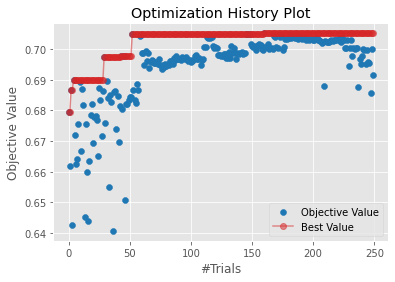

In [30]:

from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


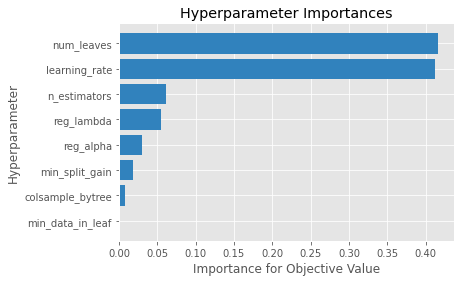

In [31]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

## Entreno LGBM con los mejroes hiperparametros

In [33]:
LGBM_t = LGBMClassifier(**selected_params, verbose=0, n_jobs=-1)

In [42]:
X_pre_pd = pd.DataFrame(X_pre)
X_pre_pd.columns = cols_tr


In [43]:
X_pre_pd.columns = cols_tr

In [44]:
LGBM_t.fit(X_pre_pd,y)


[LightGBM] [Warning] min_data_in_leaf is set=14634, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14634
[LightGBM] [Warning] min_data_in_leaf is set=14634, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14634
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


LGBMClassifier(colsample_bytree=0.2576276783401137,
               learning_rate=0.009844458872438205, min_data_in_leaf=14634,
               min_split_gain=0.02125723672974902, n_estimators=273,
               num_leaves=12, random_state=42, reg_alpha=0.2540326975041363,
               reg_lambda=0.5112080837627384, verbose=0)

In [45]:
train_out = LGBM_t.predict_proba(X_pre_pd)
test_out  = LGBM_t.predict_proba(X_val_pre)

In [46]:
print("ROC Train: "+str(roc_auc_score(np.array(y),train_out[:,1])))
print("ROC Val: "+str(roc_auc_score(np.array(y_val),test_out[:,1])))

ROC Train: 0.7078610553443951
ROC Val: 0.7065267887907428


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

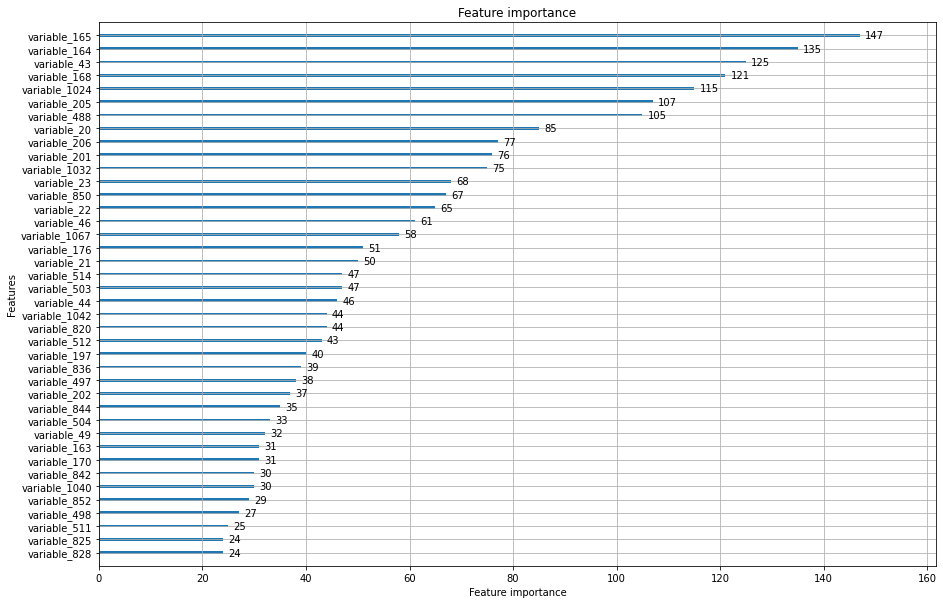

In [47]:
lgb.plot_importance(LGBM_t,max_num_features = 40,figsize=(15,10))

In [58]:
feature_imp = pd.DataFrame(sorted(zip(LGBM_t.feature_importances_,X_pre_pd.columns)), columns=['Value','Feature']).sort_values('Value',ascending=False)


In [60]:
feature_imp.query('Value > 0')

,Value,Feature
899,147,variable_165
898,135,variable_164
897,125,variable_43
896,121,variable_168
895,115,variable_1024
...,...,...
775,1,variable_827
776,1,variable_835
777,1,variable_856
779,1,variable_962


In [63]:
feature_imp.to_csv('./tp/results/feature_imp_allcols.csv',index=False)

In [37]:
train_out

array([[0.79548333, 0.20451667],
       [0.8946382 , 0.1053618 ],
       [0.83810893, 0.16189107],
       ...,
       [0.86548036, 0.13451964],
       [0.78765016, 0.21234984],
       [0.77090002, 0.22909998]])

In [38]:
pipe = make_pipeline(preprocessor,LGBM_t)

In [39]:
roc_auc_score(df2.target,pipe.predict_proba(df2)[:,1])

0.707466913090922

In [40]:
import joblib
joblib.dump(pipe, './tp/lgbm_allcols.pkl')


['./tp/lgbm_allcols.pkl']

In [5]:
import joblib


In [8]:
pipe = joblib.load('./tp/lgbm_allcols.pkl')

In [50]:
oot = oot.replace('None',np.nan)

In [51]:
roc_auc_score(oot.dropna(subset=['target']).target,pipe.predict_proba(oot.dropna(subset=['target']))[:,1])

0.696700126063833

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

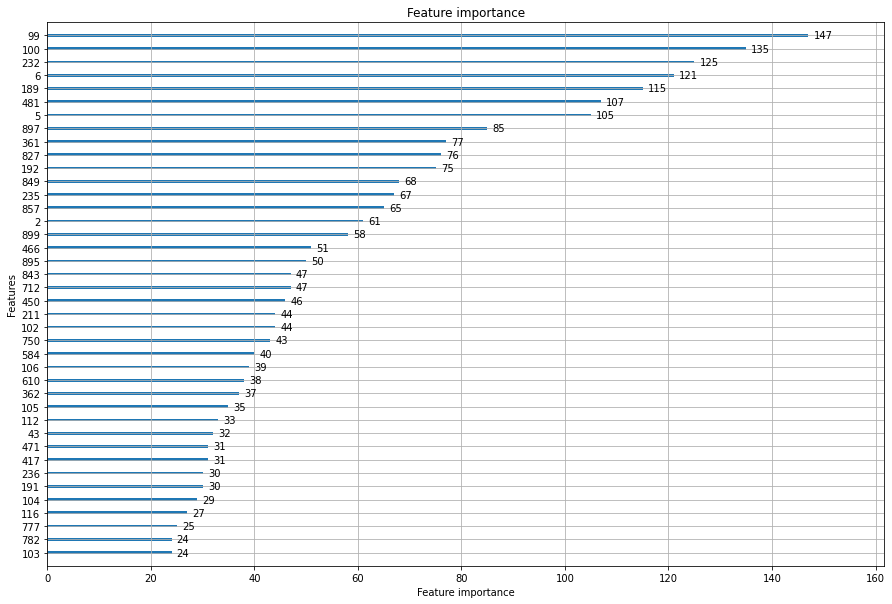

In [13]:
lgb.plot_importance(pipe[1],max_num_features = 40,figsize=(15,10))


<Figure size 432x288 with 0 Axes>

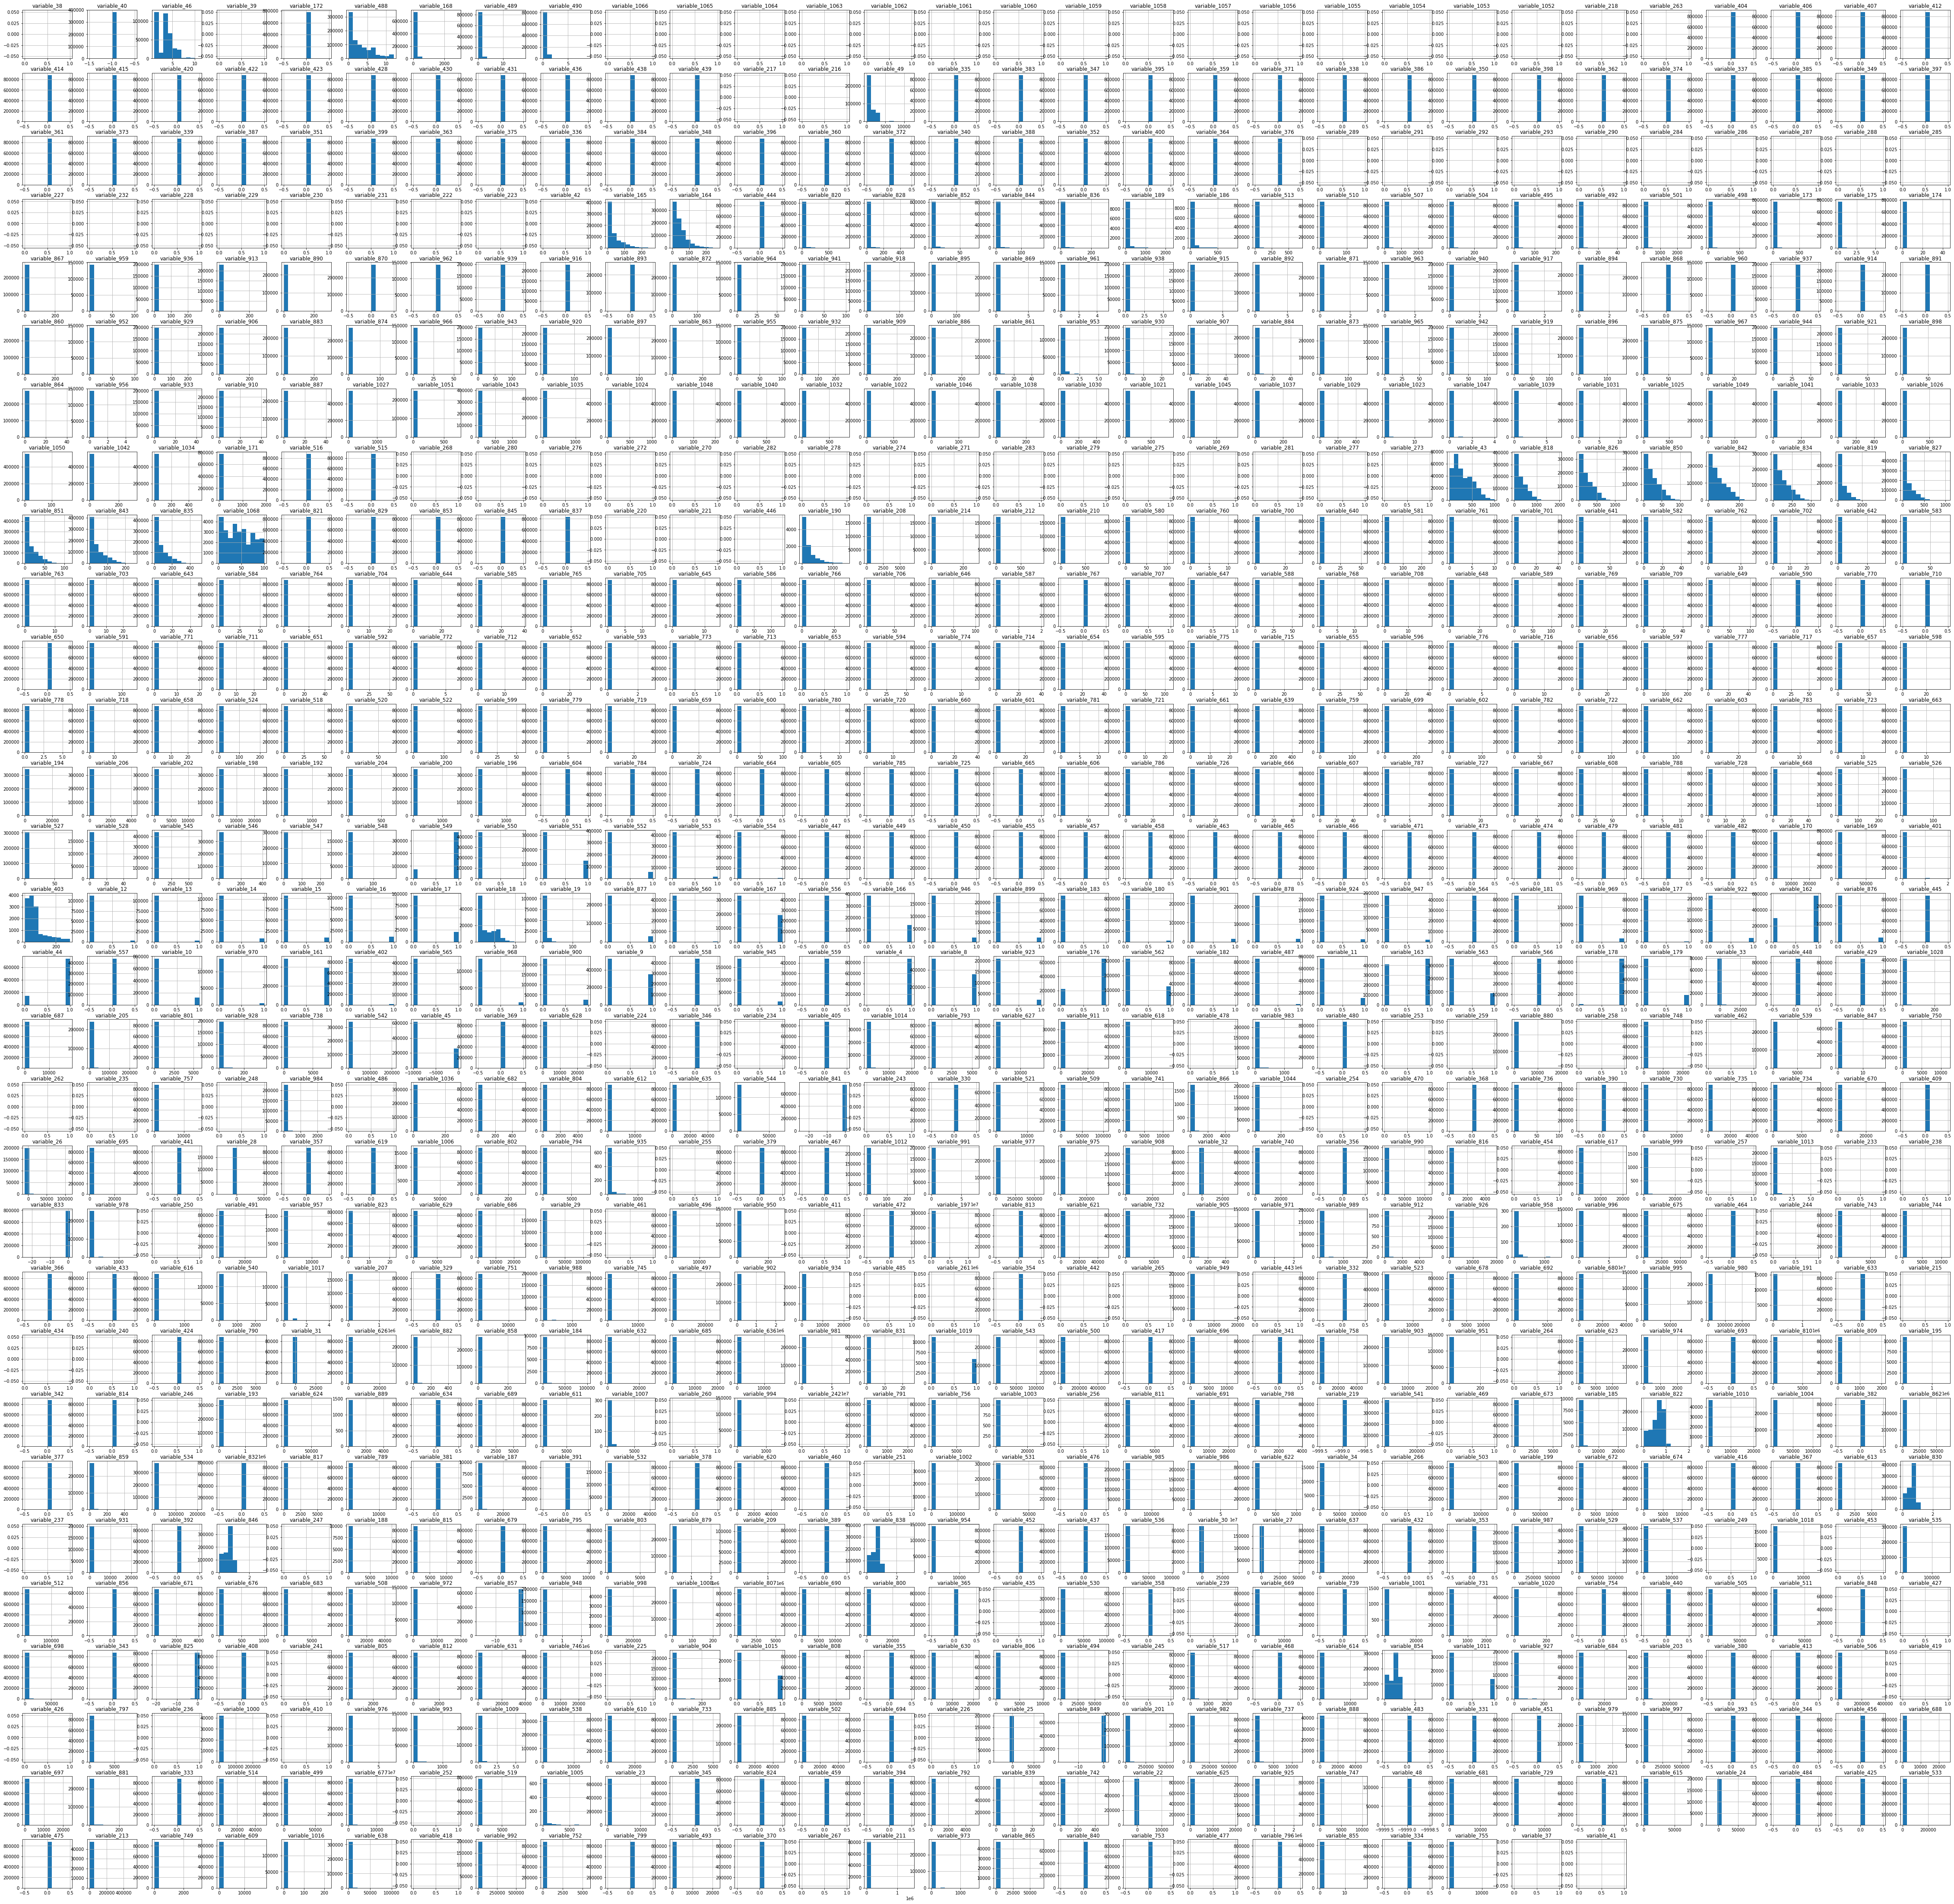

In [13]:
plt.figure()
df[numeric_features].hist(figsize=(80,80))
plt.savefig('distribuciones')
plt.show()

In [6]:
pip freeze

aiobotocore==2.1.2
aiohttp==3.8.1
aioitertools==0.8.0
aiosignal==1.2.0
alembic==1.7.7
aniso8601==9.0.1
app==0.0.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
async-timeout==4.0.2
asynctest==0.13.0
atomicwrites==1.4.0
attrs==21.2.0
autopage==0.5.0
autovizwidget==0.20.0
backcall==0.2.0
beautifulsoup4==4.11.1
bitarray==2.4.0
bleach==5.0.1
boto3==1.20.24
botocore==1.23.24
cachetools==4.2.4
category-encoders==2.4.0
certifi==2020.12.5
cffi==1.15.0
charset-normalizer==2.0.7
click==8.0.3
cliff==3.10.1
cmaes==0.8.2
cmd2==2.4.1
colorama==0.4.4
colorlog==6.6.0
contextlib2==21.6.0
coverage==4.5.2
cryptography==35.0.0
cycler==0.11.0
Cython==0.29.28
dataclasses-json==0.5.3
datadog==0.40.1
debugpy==1.6.2
decorator==5.1.0
defusedxml==0.7.1
docutils==0.16
emoji==1.6.1
entrypoints==0.4
fastjsonschema==2.15.3
fda==0.2.10
fda-toolkit==0.8.0
Flask==1.1.2
Flask-RESTful==0.3.8
fonttools==4.31.2
frozendict==2.0.6
frozenlist==1.3.0
fsspec==2022.2.0
future==0.18.2
gevent==20.9.0
gitdb==4.0.7
GitPython==3.1